# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [2]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [3]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [4]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [5]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

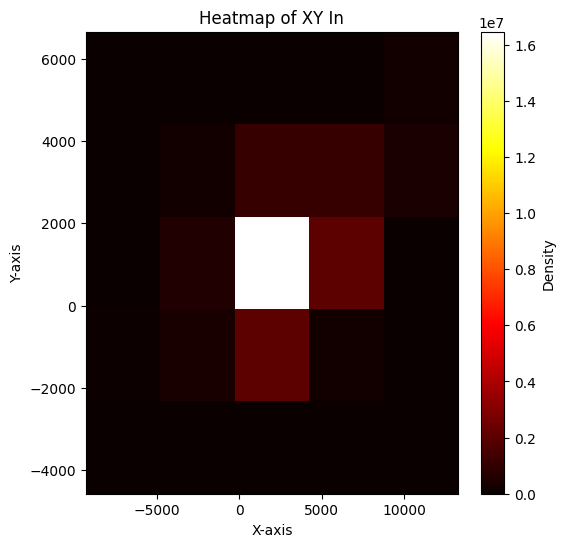

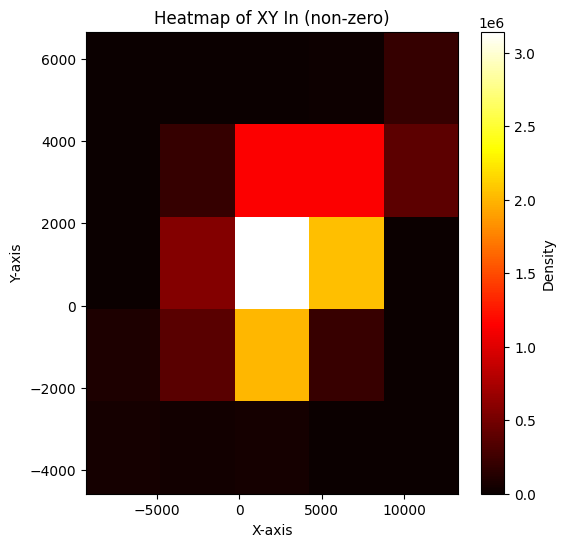

In [6]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

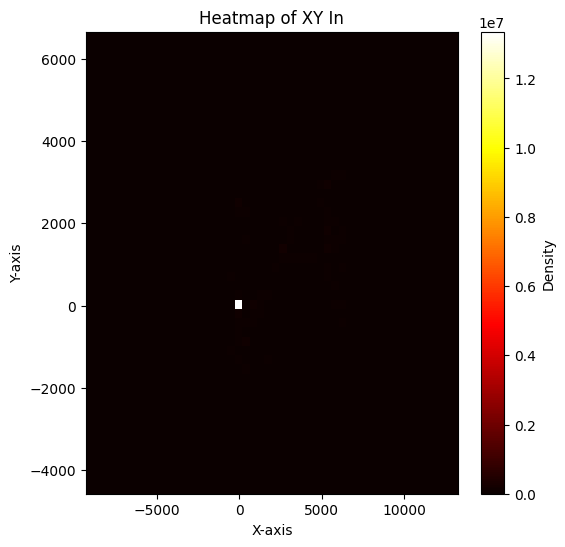

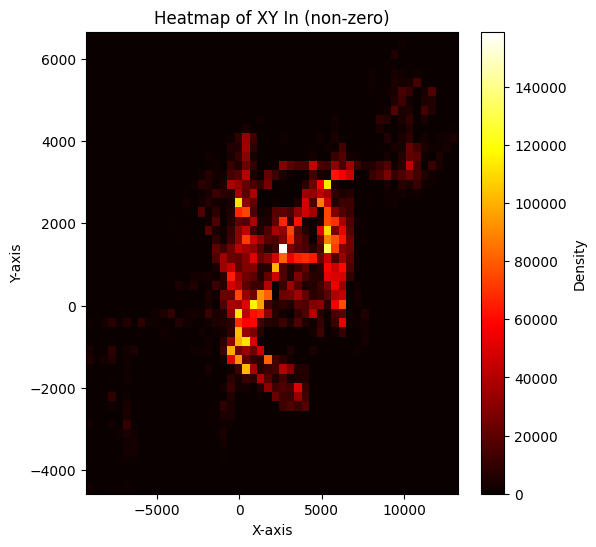

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [8]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [9]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x)
)
val_dataloader = DataLoader(
    val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
)

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [10]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [11]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

#### Trying Transformer Model

In [13]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=6, model_dim=128, num_heads=4, num_layers=2, output_dim=60*2, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, output_dim)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent index 0, shape: (batch, 50, 6)
        x = self.input_proj(x)  # (batch, 50, model_dim)
        x = self.transformer_encoder(x)  # (batch, 50, model_dim)
        out = self.fc(x[:, -1, :])  # Use last time step's output
        return out.view(-1, 60, 2)

In [14]:
class AdvancedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len
        self.input_proj = nn.Linear(input_dim, model_dim)
        
        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*4,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Decoder for future trajectory
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch, agents, seq, features)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        x = self.input_proj(x)  # (batch, seq, model_dim)
        x = x + self.pos_encoding[:, :self.seq_len, :]  # Add positional encoding
        x = self.encoder(x)  # (batch, seq, model_dim)
        x = x[:, -1, :]  # Use last time step's output (batch, model_dim)
        out = self.decoder(x)  # (batch, future_len*2)
        return out.view(-1, self.future_len, 2)

In [15]:
class BeefedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len

        # Temporal convolution for local feature extraction
        self.temporal_conv = nn.Conv1d(input_dim, input_dim, kernel_size=3, padding=1, groups=input_dim)
        self.input_proj = nn.Linear(input_dim, model_dim)

        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*6,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Deeper MLP decoder with residual connection
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim*2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim*2, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        # Temporal convolution
        x = x.transpose(1, 2)  # (batch, features, seq)
        x = self.temporal_conv(x)
        x = x.transpose(1, 2)  # (batch, seq, features)
        x = self.input_proj(x)
        x = x + self.pos_encoding[:, :self.seq_len, :]
        x = self.encoder(x)
        x = x[:, -1, :]  # Last time step
        out = self.decoder(x)
        return out.view(-1, self.future_len, 2)

In [16]:
class EnhancedTransformerModel(nn.Module):
    def __init__(self, input_dim=6, model_dim=256, num_heads=8, num_layers=4, output_dim=60*2, dropout=0.15, seq_len=50):
        super().__init__()
        self.seq_len = seq_len
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))
        self.agent_type_embedding = nn.Parameter(torch.randn(1, model_dim))
        self.temporal_conv = nn.Conv1d(model_dim, model_dim, kernel_size=3, padding=1, groups=model_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim * 2, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, output_dim)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]  # Only ego agent
        x = self.input_proj(x)
        x = x + self.pos_encoding[:, :x.size(1), :]
        x = x + self.agent_type_embedding
        x = x.transpose(1, 2)
        x = self.temporal_conv(x)
        x = x.transpose(1, 2)
        x = self.transformer_encoder(x)
        out = self.fc(x[:, -1, :])
        return out.view(-1, 60, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [17]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
# model = TransformerModel().to(device)
# model = AdvancedTransformerModel().to(device)
# model = AdvancedTransformerModel(
#     input_dim=6,
#     model_dim=512,      # 2x wider
#     num_heads=16,       # 2x more heads
#     num_layers=12,      # 2x deeper
#     seq_len=50,
#     future_len=60,
#     dropout=0.10        # Slightly higher dropout for regularization
# ).to(device)
# model = BeefedTransformerModel(
#     input_dim=6,
#     model_dim=1152,
#     num_heads=36,
#     num_layers=20,
#     seq_len=50,
#     future_len=60,
#     dropout=0.15
# ).to(device)
# model_dim=128, num_heads=4, num_layers=2


#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [ ]:
from sklearn.model_selection import KFold

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
all_indices = np.arange(len(train_data))
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices)):
    print(f"\n--- Fold {fold+1}/{k_folds} ---")

    # Create datasets for this fold
    train_dataset = TrajectoryDatasetTrain(train_data[train_idx], scale=scale, augment=True)
    val_dataset = TrajectoryDatasetTrain(train_data[val_idx], scale=scale, augment=False)
    train_dataloader = DataLoader(
        train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x)
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
    )
    
    model = EnhancedTransformerModel(
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=4,
        dropout=0
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=1e-3,
        total_steps=100 * len(train_dataloader),
        pct_start=0.1,
        div_factor=10.0,
        final_div_factor=100.0
    )
    early_stopping_patience = 20
    best_val_loss = float('inf')
    no_improvement = 0
    criterion = nn.MSELoss()

    for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item()
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                val_loss += criterion(pred, y).item()

                # show MAE and MSE with unnormalized data
                pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                val_mae += nn.L1Loss()(pred, y).item()
                val_mse += nn.MSELoss()(pred, y).item()
        
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_mse /= len(val_dataloader)
        scheduler.step()
        # scheduler.step(val_loss)
        
        tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), f"best_model_fold{fold+1}.pt")
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print("Early stop!")
                break

    fold_results.append(best_val_loss)

print(f"\nK-Fold Results: {fold_results}")
print(f"Mean Validation Loss: {np.mean(fold_results):.4f} | Std: {np.std(fold_results):.4f}")


--- Fold 1/5 ---


C:\Users\Brian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
Epoch:   1%|          | 1/100 [00:04<07:11,  4.36s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.4128 | val normalized MSE   0.7864, | val MAE   4.0301 | val MSE  38.5315


Epoch:   2%|▏         | 2/100 [00:08<06:57,  4.26s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.5397 | val normalized MSE   0.4140, | val MAE   2.5491 | val MSE  20.2858


Epoch:   3%|▎         | 3/100 [00:12<06:56,  4.29s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3991 | val normalized MSE   0.3569, | val MAE   2.3646 | val MSE  17.4895


Epoch:   4%|▍         | 4/100 [00:16<06:41,  4.18s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.4079 | val normalized MSE   0.3889, | val MAE   2.5617 | val MSE  19.0576


Epoch:   5%|▌         | 5/100 [00:20<06:30,  4.12s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3524 | val normalized MSE   0.3043, | val MAE   2.1452 | val MSE  14.9128


Epoch:   6%|▌         | 6/100 [00:24<06:18,  4.03s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.3271 | val normalized MSE   0.3107, | val MAE   2.0825 | val MSE  15.2222


Epoch:   7%|▋         | 7/100 [00:28<06:10,  3.98s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2886 | val normalized MSE   0.3088, | val MAE   2.1199 | val MSE  15.1319


Epoch:   8%|▊         | 8/100 [00:32<06:02,  3.94s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.3047 | val normalized MSE   0.3158, | val MAE   2.2888 | val MSE  15.4742


Epoch:   9%|▉         | 9/100 [00:36<06:02,  3.98s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2951 | val normalized MSE   0.3136, | val MAE   2.3337 | val MSE  15.3659


Epoch:  10%|█         | 10/100 [00:40<06:03,  4.04s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.3017 | val normalized MSE   0.2919, | val MAE   2.1021 | val MSE  14.3051


Epoch:  11%|█         | 11/100 [00:44<06:01,  4.06s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2688 | val normalized MSE   0.2717, | val MAE   1.9516 | val MSE  13.3143


Epoch:  12%|█▏        | 12/100 [00:49<06:01,  4.11s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2662 | val normalized MSE   0.2772, | val MAE   2.1571 | val MSE  13.5846


Epoch:  13%|█▎        | 13/100 [00:53<05:58,  4.12s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2687 | val normalized MSE   0.2796, | val MAE   2.0624 | val MSE  13.7007


Epoch:  14%|█▍        | 14/100 [00:57<05:59,  4.18s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2663 | val normalized MSE   0.2479, | val MAE   1.8565 | val MSE  12.1473


Epoch:  15%|█▌        | 15/100 [01:01<05:49,  4.12s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2746 | val normalized MSE   0.3150, | val MAE   2.2635 | val MSE  15.4373


Epoch:  16%|█▌        | 16/100 [01:05<05:41,  4.06s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2713 | val normalized MSE   0.2779, | val MAE   1.9828 | val MSE  13.6149


Epoch:  17%|█▋        | 17/100 [01:09<05:33,  4.02s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2596 | val normalized MSE   0.3056, | val MAE   2.1295 | val MSE  14.9739


Epoch:  18%|█▊        | 18/100 [01:13<05:25,  3.96s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2592 | val normalized MSE   0.2858, | val MAE   1.9790 | val MSE  14.0022


Epoch:  19%|█▉        | 19/100 [01:17<05:20,  3.96s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2560 | val normalized MSE   0.2875, | val MAE   2.1408 | val MSE  14.0886


Epoch:  20%|██        | 20/100 [01:20<05:13,  3.92s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2573 | val normalized MSE   0.2872, | val MAE   2.2041 | val MSE  14.0741


Epoch:  21%|██        | 21/100 [01:24<05:08,  3.90s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2217 | val normalized MSE   0.2237, | val MAE   1.6198 | val MSE  10.9617


Epoch:  22%|██▏       | 22/100 [01:28<05:08,  3.96s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2143 | val normalized MSE   0.2210, | val MAE   1.6713 | val MSE  10.8296


Epoch:  23%|██▎       | 23/100 [01:32<05:05,  3.97s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2128 | val normalized MSE   0.2149, | val MAE   1.5643 | val MSE  10.5283


Epoch:  24%|██▍       | 24/100 [01:37<05:05,  4.02s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2122 | val normalized MSE   0.2166, | val MAE   1.5785 | val MSE  10.6123


Epoch:  25%|██▌       | 25/100 [01:41<05:03,  4.04s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2169 | val normalized MSE   0.2204, | val MAE   1.6348 | val MSE  10.7982


Epoch:  26%|██▌       | 26/100 [01:45<04:59,  4.04s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2122 | val normalized MSE   0.2227, | val MAE   1.7003 | val MSE  10.9142


Epoch:  27%|██▋       | 27/100 [01:49<04:56,  4.06s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2112 | val normalized MSE   0.2318, | val MAE   1.7599 | val MSE  11.3605


Epoch:  28%|██▊       | 28/100 [01:53<04:53,  4.08s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.2106 | val normalized MSE   0.2107, | val MAE   1.5870 | val MSE  10.3244


Epoch:  29%|██▉       | 29/100 [01:57<04:51,  4.10s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.2088 | val normalized MSE   0.2144, | val MAE   1.6270 | val MSE  10.5065


Epoch:  30%|███       | 30/100 [02:01<04:46,  4.10s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.2140 | val normalized MSE   0.2189, | val MAE   1.7030 | val MSE  10.7279


Epoch:  31%|███       | 31/100 [02:05<04:43,  4.11s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.2104 | val normalized MSE   0.2156, | val MAE   1.6100 | val MSE  10.5622


Epoch:  32%|███▏      | 32/100 [02:09<04:37,  4.08s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.2109 | val normalized MSE   0.2107, | val MAE   1.6531 | val MSE  10.3267


Epoch:  33%|███▎      | 33/100 [02:13<04:32,  4.07s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.2104 | val normalized MSE   0.2227, | val MAE   1.8039 | val MSE  10.9140


Epoch:  34%|███▍      | 34/100 [02:17<04:29,  4.09s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.2100 | val normalized MSE   0.2106, | val MAE   1.5995 | val MSE  10.3203


Epoch:  35%|███▌      | 35/100 [02:22<04:25,  4.09s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.2097 | val normalized MSE   0.2187, | val MAE   1.6460 | val MSE  10.7172


Epoch:  36%|███▌      | 36/100 [02:26<04:20,  4.07s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.2105 | val normalized MSE   0.2140, | val MAE   1.6905 | val MSE  10.4869


Epoch:  37%|███▋      | 37/100 [02:30<04:18,  4.11s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.2126 | val normalized MSE   0.2105, | val MAE   1.6001 | val MSE  10.3122


Epoch:  38%|███▊      | 38/100 [02:34<04:15,  4.13s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.2068 | val normalized MSE   0.2103, | val MAE   1.6364 | val MSE  10.3033


Epoch:  39%|███▉      | 39/100 [02:38<04:12,  4.14s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.2101 | val normalized MSE   0.2053, | val MAE   1.5604 | val MSE  10.0599


Epoch:  40%|████      | 40/100 [02:42<04:06,  4.12s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.2056 | val normalized MSE   0.2137, | val MAE   1.7434 | val MSE  10.4736


Epoch:  41%|████      | 41/100 [02:46<04:02,  4.11s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1924 | val normalized MSE   0.1988, | val MAE   1.5137 | val MSE   9.7434


Epoch:  42%|████▏     | 42/100 [02:50<03:56,  4.08s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1905 | val normalized MSE   0.1988, | val MAE   1.4866 | val MSE   9.7410


Epoch:  43%|████▎     | 43/100 [02:54<03:52,  4.08s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1901 | val normalized MSE   0.1977, | val MAE   1.4981 | val MSE   9.6862


Epoch:  44%|████▍     | 44/100 [02:59<03:49,  4.09s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1903 | val normalized MSE   0.1964, | val MAE   1.4953 | val MSE   9.6237


Epoch:  45%|████▌     | 45/100 [03:03<03:45,  4.09s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1896 | val normalized MSE   0.1960, | val MAE   1.5218 | val MSE   9.6061


Epoch:  46%|████▌     | 46/100 [03:07<03:41,  4.10s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1905 | val normalized MSE   0.1947, | val MAE   1.4764 | val MSE   9.5395


Epoch:  47%|████▋     | 47/100 [03:11<03:40,  4.16s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1876 | val normalized MSE   0.1947, | val MAE   1.4842 | val MSE   9.5381


Epoch:  48%|████▊     | 48/100 [03:15<03:39,  4.22s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1882 | val normalized MSE   0.2026, | val MAE   1.5247 | val MSE   9.9250


Epoch:  49%|████▉     | 49/100 [03:20<03:34,  4.21s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1881 | val normalized MSE   0.1948, | val MAE   1.4790 | val MSE   9.5441


Epoch:  50%|█████     | 50/100 [03:24<03:27,  4.15s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1869 | val normalized MSE   0.1952, | val MAE   1.4873 | val MSE   9.5632


Epoch:  51%|█████     | 51/100 [03:28<03:21,  4.11s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1877 | val normalized MSE   0.1942, | val MAE   1.5067 | val MSE   9.5171


Epoch:  52%|█████▏    | 52/100 [03:32<03:19,  4.15s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1881 | val normalized MSE   0.2026, | val MAE   1.5669 | val MSE   9.9260


Epoch:  53%|█████▎    | 53/100 [03:36<03:14,  4.14s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1883 | val normalized MSE   0.1972, | val MAE   1.5158 | val MSE   9.6645


Epoch:  54%|█████▍    | 54/100 [03:40<03:10,  4.14s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1847 | val normalized MSE   0.1917, | val MAE   1.4591 | val MSE   9.3918


Epoch:  55%|█████▌    | 55/100 [03:44<03:04,  4.11s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1861 | val normalized MSE   0.1948, | val MAE   1.5431 | val MSE   9.5445


Epoch:  56%|█████▌    | 56/100 [03:48<03:00,  4.11s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1862 | val normalized MSE   0.1916, | val MAE   1.4855 | val MSE   9.3899


Epoch:  57%|█████▋    | 57/100 [03:53<03:00,  4.19s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1836 | val normalized MSE   0.1917, | val MAE   1.4601 | val MSE   9.3920


Epoch:  58%|█████▊    | 58/100 [03:57<02:57,  4.21s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1846 | val normalized MSE   0.1977, | val MAE   1.5657 | val MSE   9.6874


Epoch:  59%|█████▉    | 59/100 [04:01<02:52,  4.20s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1859 | val normalized MSE   0.1983, | val MAE   1.4734 | val MSE   9.7189


Epoch:  60%|██████    | 60/100 [04:05<02:46,  4.16s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1850 | val normalized MSE   0.1939, | val MAE   1.4798 | val MSE   9.5029


Epoch:  61%|██████    | 61/100 [04:09<02:40,  4.12s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1803 | val normalized MSE   0.1893, | val MAE   1.4406 | val MSE   9.2773


Epoch:  62%|██████▏   | 62/100 [04:13<02:37,  4.13s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1784 | val normalized MSE   0.1904, | val MAE   1.4409 | val MSE   9.3280


Epoch:  63%|██████▎   | 63/100 [04:18<02:34,  4.16s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1789 | val normalized MSE   0.1884, | val MAE   1.4195 | val MSE   9.2306


Epoch:  64%|██████▍   | 64/100 [04:22<02:28,  4.14s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1781 | val normalized MSE   0.1893, | val MAE   1.4374 | val MSE   9.2768


Epoch:  65%|██████▌   | 65/100 [04:26<02:24,  4.13s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1789 | val normalized MSE   0.1873, | val MAE   1.4378 | val MSE   9.1799


Epoch:  66%|██████▌   | 66/100 [04:30<02:19,  4.09s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1791 | val normalized MSE   0.1888, | val MAE   1.4450 | val MSE   9.2494


Epoch:  67%|██████▋   | 67/100 [04:34<02:17,  4.17s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1774 | val normalized MSE   0.1897, | val MAE   1.4610 | val MSE   9.2974


Epoch:  68%|██████▊   | 68/100 [04:38<02:14,  4.22s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1797 | val normalized MSE   0.1870, | val MAE   1.4367 | val MSE   9.1633


Epoch:  69%|██████▉   | 69/100 [04:43<02:11,  4.23s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1775 | val normalized MSE   0.1890, | val MAE   1.4275 | val MSE   9.2593


Epoch:  70%|███████   | 70/100 [04:47<02:05,  4.17s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1772 | val normalized MSE   0.1879, | val MAE   1.4285 | val MSE   9.2056


Epoch:  71%|███████   | 71/100 [04:51<02:00,  4.14s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1763 | val normalized MSE   0.1873, | val MAE   1.4154 | val MSE   9.1787


Epoch:  72%|███████▏  | 72/100 [04:55<01:56,  4.14s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1788 | val normalized MSE   0.1888, | val MAE   1.4439 | val MSE   9.2528


Epoch:  73%|███████▎  | 73/100 [04:59<01:51,  4.13s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1766 | val normalized MSE   0.1873, | val MAE   1.4171 | val MSE   9.1756


Epoch:  74%|███████▍  | 74/100 [05:03<01:46,  4.11s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1774 | val normalized MSE   0.1862, | val MAE   1.4089 | val MSE   9.1250


Epoch:  75%|███████▌  | 75/100 [05:07<01:42,  4.11s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1766 | val normalized MSE   0.1893, | val MAE   1.4392 | val MSE   9.2778


Epoch:  76%|███████▌  | 76/100 [05:11<01:39,  4.15s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1769 | val normalized MSE   0.1866, | val MAE   1.4198 | val MSE   9.1447


Epoch:  77%|███████▋  | 77/100 [05:16<01:35,  4.15s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1769 | val normalized MSE   0.1878, | val MAE   1.4244 | val MSE   9.2017


Epoch:  78%|███████▊  | 78/100 [05:20<01:31,  4.14s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1758 | val normalized MSE   0.1912, | val MAE   1.4791 | val MSE   9.3675


Epoch:  79%|███████▉  | 79/100 [05:24<01:27,  4.16s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1771 | val normalized MSE   0.1916, | val MAE   1.4495 | val MSE   9.3908


Epoch:  80%|████████  | 80/100 [05:28<01:22,  4.14s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1774 | val normalized MSE   0.1887, | val MAE   1.4791 | val MSE   9.2440


Epoch:  81%|████████  | 81/100 [05:32<01:18,  4.15s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1744 | val normalized MSE   0.1851, | val MAE   1.4118 | val MSE   9.0716


Epoch:  82%|████████▏ | 82/100 [05:36<01:14,  4.15s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1742 | val normalized MSE   0.1859, | val MAE   1.4076 | val MSE   9.1093


Epoch:  83%|████████▎ | 83/100 [05:40<01:10,  4.13s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1742 | val normalized MSE   0.1854, | val MAE   1.4050 | val MSE   9.0856


Epoch:  84%|████████▍ | 84/100 [05:44<01:05,  4.10s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1747 | val normalized MSE   0.1857, | val MAE   1.4058 | val MSE   9.1006


Epoch:  85%|████████▌ | 85/100 [05:48<01:01,  4.09s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1747 | val normalized MSE   0.1857, | val MAE   1.4092 | val MSE   9.1015


Epoch:  86%|████████▌ | 86/100 [05:53<00:57,  4.12s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1739 | val normalized MSE   0.1854, | val MAE   1.4076 | val MSE   9.0825


Epoch:  87%|████████▋ | 87/100 [05:57<00:53,  4.11s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1749 | val normalized MSE   0.1858, | val MAE   1.4060 | val MSE   9.1026


Epoch:  88%|████████▊ | 88/100 [06:01<00:49,  4.11s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1730 | val normalized MSE   0.1855, | val MAE   1.4005 | val MSE   9.0914


Epoch:  89%|████████▉ | 89/100 [06:05<00:45,  4.09s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1735 | val normalized MSE   0.1854, | val MAE   1.4040 | val MSE   9.0829


Epoch:  90%|█████████ | 90/100 [06:09<00:41,  4.12s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1736 | val normalized MSE   0.1853, | val MAE   1.4185 | val MSE   9.0783


Epoch:  91%|█████████ | 91/100 [06:13<00:37,  4.15s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1733 | val normalized MSE   0.1854, | val MAE   1.4043 | val MSE   9.0833


Epoch:  92%|█████████▏| 92/100 [06:17<00:33,  4.14s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1744 | val normalized MSE   0.1848, | val MAE   1.4043 | val MSE   9.0569


Epoch:  93%|█████████▎| 93/100 [06:22<00:29,  4.15s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1733 | val normalized MSE   0.1849, | val MAE   1.4100 | val MSE   9.0609


Epoch:  94%|█████████▍| 94/100 [06:26<00:24,  4.13s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1746 | val normalized MSE   0.1849, | val MAE   1.4070 | val MSE   9.0608


Epoch:  95%|█████████▌| 95/100 [06:30<00:20,  4.14s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1729 | val normalized MSE   0.1856, | val MAE   1.4058 | val MSE   9.0953


Epoch:  96%|█████████▌| 96/100 [06:34<00:16,  4.13s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1735 | val normalized MSE   0.1857, | val MAE   1.4092 | val MSE   9.0987


Epoch:  97%|█████████▋| 97/100 [06:38<00:12,  4.14s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1732 | val normalized MSE   0.1855, | val MAE   1.4038 | val MSE   9.0916


Epoch:  98%|█████████▊| 98/100 [06:42<00:08,  4.16s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1736 | val normalized MSE   0.1857, | val MAE   1.4180 | val MSE   9.1000


Epoch:  99%|█████████▉| 99/100 [06:47<00:04,  4.22s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1726 | val normalized MSE   0.1851, | val MAE   1.4066 | val MSE   9.0723


Epoch: 100%|██████████| 100/100 [06:51<00:00,  4.12s/epoch]


Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1736 | val normalized MSE   0.1849, | val MAE   1.4070 | val MSE   9.0591

--- Fold 2/5 ---


Epoch:   1%|          | 1/100 [00:04<06:54,  4.19s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.5621 | val normalized MSE   0.6946, | val MAE   3.6373 | val MSE  34.0347


Epoch:   2%|▏         | 2/100 [00:08<06:52,  4.21s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.5871 | val normalized MSE   0.4457, | val MAE   2.6447 | val MSE  21.8384


Epoch:   3%|▎         | 3/100 [00:12<06:44,  4.17s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.4722 | val normalized MSE   0.4511, | val MAE   2.5748 | val MSE  22.1025


Epoch:   4%|▍         | 4/100 [00:16<06:39,  4.16s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.4012 | val normalized MSE   0.3959, | val MAE   2.4979 | val MSE  19.3971


Epoch:   5%|▌         | 5/100 [00:20<06:36,  4.17s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3832 | val normalized MSE   0.3649, | val MAE   2.3858 | val MSE  17.8786


Epoch:   6%|▌         | 6/100 [00:25<06:39,  4.25s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.3442 | val normalized MSE   0.3653, | val MAE   2.5434 | val MSE  17.8978


Epoch:   7%|▋         | 7/100 [00:29<06:38,  4.28s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.3264 | val normalized MSE   0.2915, | val MAE   2.0973 | val MSE  14.2838


Epoch:   8%|▊         | 8/100 [00:34<06:36,  4.31s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.3400 | val normalized MSE   0.2914, | val MAE   2.1486 | val MSE  14.2800


Epoch:   9%|▉         | 9/100 [00:38<06:35,  4.35s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.3105 | val normalized MSE   0.3037, | val MAE   2.1515 | val MSE  14.8812


Epoch:  10%|█         | 10/100 [00:42<06:19,  4.22s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.3023 | val normalized MSE   0.2993, | val MAE   2.2524 | val MSE  14.6661


Epoch:  11%|█         | 11/100 [00:46<06:08,  4.14s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2899 | val normalized MSE   0.2908, | val MAE   2.1787 | val MSE  14.2502


Epoch:  12%|█▏        | 12/100 [00:50<05:57,  4.07s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2946 | val normalized MSE   0.3078, | val MAE   2.2584 | val MSE  15.0797


Epoch:  13%|█▎        | 13/100 [00:53<05:45,  3.97s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2860 | val normalized MSE   0.2861, | val MAE   2.1112 | val MSE  14.0176


Epoch:  14%|█▍        | 14/100 [00:58<05:44,  4.01s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2792 | val normalized MSE   0.2578, | val MAE   2.0098 | val MSE  12.6306


Epoch:  15%|█▌        | 15/100 [01:01<05:35,  3.94s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2684 | val normalized MSE   0.2622, | val MAE   1.9280 | val MSE  12.8457


Epoch:  16%|█▌        | 16/100 [01:05<05:25,  3.88s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2749 | val normalized MSE   0.2620, | val MAE   1.9439 | val MSE  12.8378


Epoch:  17%|█▋        | 17/100 [01:09<05:16,  3.82s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2613 | val normalized MSE   0.2615, | val MAE   1.9123 | val MSE  12.8136


Epoch:  18%|█▊        | 18/100 [01:13<05:13,  3.82s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2858 | val normalized MSE   0.3088, | val MAE   2.2365 | val MSE  15.1289


Epoch:  19%|█▉        | 19/100 [01:17<05:13,  3.86s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2853 | val normalized MSE   0.2545, | val MAE   1.9566 | val MSE  12.4701


Epoch:  20%|██        | 20/100 [01:20<05:09,  3.87s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2592 | val normalized MSE   0.2202, | val MAE   1.7118 | val MSE  10.7906


Epoch:  21%|██        | 21/100 [01:24<05:05,  3.86s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2153 | val normalized MSE   0.2169, | val MAE   1.6407 | val MSE  10.6298


Epoch:  22%|██▏       | 22/100 [01:28<05:00,  3.85s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2107 | val normalized MSE   0.2299, | val MAE   1.7289 | val MSE  11.2660


Epoch:  23%|██▎       | 23/100 [01:32<04:56,  3.85s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2135 | val normalized MSE   0.2403, | val MAE   1.9242 | val MSE  11.7759


Epoch:  24%|██▍       | 24/100 [01:36<04:53,  3.87s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2091 | val normalized MSE   0.2071, | val MAE   1.5504 | val MSE  10.1494


Epoch:  25%|██▌       | 25/100 [01:40<04:49,  3.86s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2106 | val normalized MSE   0.2210, | val MAE   1.7083 | val MSE  10.8304


Epoch:  26%|██▌       | 26/100 [01:44<04:45,  3.85s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2093 | val normalized MSE   0.2135, | val MAE   1.6797 | val MSE  10.4634


Epoch:  27%|██▋       | 27/100 [01:47<04:38,  3.81s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2178 | val normalized MSE   0.2021, | val MAE   1.5271 | val MSE   9.9037


Epoch:  28%|██▊       | 28/100 [01:51<04:33,  3.79s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.2072 | val normalized MSE   0.2177, | val MAE   1.5915 | val MSE  10.6657


Epoch:  29%|██▉       | 29/100 [01:55<04:29,  3.80s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.2128 | val normalized MSE   0.2040, | val MAE   1.5696 | val MSE   9.9943


Epoch:  30%|███       | 30/100 [01:59<04:25,  3.79s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.2106 | val normalized MSE   0.2228, | val MAE   1.6705 | val MSE  10.9159


Epoch:  31%|███       | 31/100 [02:02<04:22,  3.80s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.2085 | val normalized MSE   0.2430, | val MAE   1.9273 | val MSE  11.9057


Epoch:  32%|███▏      | 32/100 [02:06<04:17,  3.79s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.2087 | val normalized MSE   0.2160, | val MAE   1.6798 | val MSE  10.5822


Epoch:  33%|███▎      | 33/100 [02:10<04:14,  3.80s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.2099 | val normalized MSE   0.2102, | val MAE   1.6884 | val MSE  10.3004


Epoch:  34%|███▍      | 34/100 [02:14<04:14,  3.86s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.2079 | val normalized MSE   0.2048, | val MAE   1.5164 | val MSE  10.0352


Epoch:  35%|███▌      | 35/100 [02:18<04:17,  3.97s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.2055 | val normalized MSE   0.2066, | val MAE   1.5683 | val MSE  10.1256


Epoch:  36%|███▌      | 36/100 [02:22<04:15,  3.99s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.2090 | val normalized MSE   0.2170, | val MAE   1.6495 | val MSE  10.6317


Epoch:  37%|███▋      | 37/100 [02:26<04:10,  3.98s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.2085 | val normalized MSE   0.2052, | val MAE   1.5452 | val MSE  10.0563


Epoch:  38%|███▊      | 38/100 [02:30<04:06,  3.98s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.2060 | val normalized MSE   0.2127, | val MAE   1.5990 | val MSE  10.4216


Epoch:  39%|███▉      | 39/100 [02:34<04:05,  4.03s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.2106 | val normalized MSE   0.2054, | val MAE   1.6014 | val MSE  10.0655


Epoch:  40%|████      | 40/100 [02:38<04:02,  4.04s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.2071 | val normalized MSE   0.2309, | val MAE   1.7841 | val MSE  11.3131


Epoch:  41%|████      | 41/100 [02:42<03:57,  4.02s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1934 | val normalized MSE   0.2010, | val MAE   1.5327 | val MSE   9.8493


Epoch:  42%|████▏     | 42/100 [02:46<03:50,  3.98s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1905 | val normalized MSE   0.1952, | val MAE   1.4794 | val MSE   9.5667


Epoch:  43%|████▎     | 43/100 [02:50<03:45,  3.95s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1903 | val normalized MSE   0.1949, | val MAE   1.4693 | val MSE   9.5476


Epoch:  44%|████▍     | 44/100 [02:54<03:41,  3.96s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1887 | val normalized MSE   0.1935, | val MAE   1.4621 | val MSE   9.4829


Epoch:  45%|████▌     | 45/100 [02:58<03:37,  3.95s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1900 | val normalized MSE   0.1950, | val MAE   1.4776 | val MSE   9.5565


Epoch:  46%|████▌     | 46/100 [03:02<03:32,  3.93s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1889 | val normalized MSE   0.1947, | val MAE   1.4861 | val MSE   9.5424


Epoch:  47%|████▋     | 47/100 [03:06<03:27,  3.92s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1916 | val normalized MSE   0.1911, | val MAE   1.4969 | val MSE   9.3622


Epoch:  48%|████▊     | 48/100 [03:10<03:23,  3.91s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1884 | val normalized MSE   0.1970, | val MAE   1.5030 | val MSE   9.6511


Epoch:  49%|████▉     | 49/100 [03:14<03:20,  3.92s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1871 | val normalized MSE   0.1917, | val MAE   1.4587 | val MSE   9.3913


Epoch:  50%|█████     | 50/100 [03:18<03:17,  3.94s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1876 | val normalized MSE   0.1894, | val MAE   1.4785 | val MSE   9.2791


Epoch:  51%|█████     | 51/100 [03:22<03:12,  3.94s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1869 | val normalized MSE   0.1900, | val MAE   1.4714 | val MSE   9.3097


Epoch:  52%|█████▏    | 52/100 [03:25<03:08,  3.93s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1880 | val normalized MSE   0.1933, | val MAE   1.5130 | val MSE   9.4722


Epoch:  53%|█████▎    | 53/100 [03:29<03:05,  3.94s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1881 | val normalized MSE   0.2043, | val MAE   1.6096 | val MSE  10.0093


Epoch:  54%|█████▍    | 54/100 [03:33<03:01,  3.94s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1870 | val normalized MSE   0.1916, | val MAE   1.4452 | val MSE   9.3875


Epoch:  55%|█████▌    | 55/100 [03:37<02:57,  3.95s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1881 | val normalized MSE   0.1931, | val MAE   1.5015 | val MSE   9.4617


Epoch:  56%|█████▌    | 56/100 [03:41<02:52,  3.92s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1857 | val normalized MSE   0.2012, | val MAE   1.5709 | val MSE   9.8587


Epoch:  57%|█████▋    | 57/100 [03:45<02:48,  3.92s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1871 | val normalized MSE   0.1936, | val MAE   1.4710 | val MSE   9.4841


Epoch:  58%|█████▊    | 58/100 [03:49<02:45,  3.94s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1865 | val normalized MSE   0.1918, | val MAE   1.4849 | val MSE   9.3995


Epoch:  59%|█████▉    | 59/100 [03:53<02:43,  3.98s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1869 | val normalized MSE   0.1919, | val MAE   1.4951 | val MSE   9.4014


Epoch:  60%|██████    | 60/100 [03:57<02:40,  4.02s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1851 | val normalized MSE   0.1929, | val MAE   1.4486 | val MSE   9.4531


Epoch:  61%|██████    | 61/100 [04:01<02:36,  4.01s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1807 | val normalized MSE   0.1884, | val MAE   1.4211 | val MSE   9.2307


Epoch:  62%|██████▏   | 62/100 [04:05<02:31,  3.98s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1811 | val normalized MSE   0.1887, | val MAE   1.4391 | val MSE   9.2451


Epoch:  63%|██████▎   | 63/100 [04:09<02:28,  4.02s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1810 | val normalized MSE   0.1876, | val MAE   1.4295 | val MSE   9.1932


Epoch:  64%|██████▍   | 64/100 [04:14<02:26,  4.06s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1801 | val normalized MSE   0.1862, | val MAE   1.4159 | val MSE   9.1245


Epoch:  65%|██████▌   | 65/100 [04:18<02:22,  4.07s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1800 | val normalized MSE   0.1875, | val MAE   1.4411 | val MSE   9.1880


Epoch:  66%|██████▌   | 66/100 [04:22<02:17,  4.04s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1800 | val normalized MSE   0.1876, | val MAE   1.4423 | val MSE   9.1922


Epoch:  67%|██████▋   | 67/100 [04:26<02:12,  4.03s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1799 | val normalized MSE   0.1897, | val MAE   1.4518 | val MSE   9.2949


Epoch:  68%|██████▊   | 68/100 [04:30<02:09,  4.05s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1803 | val normalized MSE   0.1886, | val MAE   1.4326 | val MSE   9.2412


Epoch:  69%|██████▉   | 69/100 [04:34<02:05,  4.06s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1789 | val normalized MSE   0.1881, | val MAE   1.4486 | val MSE   9.2151


Epoch:  70%|███████   | 70/100 [04:38<02:02,  4.08s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1793 | val normalized MSE   0.1868, | val MAE   1.4301 | val MSE   9.1519


Epoch:  71%|███████   | 71/100 [04:42<01:57,  4.05s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1794 | val normalized MSE   0.1867, | val MAE   1.4272 | val MSE   9.1473


Epoch:  72%|███████▏  | 72/100 [04:46<01:52,  4.03s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1794 | val normalized MSE   0.1864, | val MAE   1.4371 | val MSE   9.1335


Epoch:  73%|███████▎  | 73/100 [04:50<01:49,  4.05s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1793 | val normalized MSE   0.1877, | val MAE   1.4407 | val MSE   9.1984


Epoch:  74%|███████▍  | 74/100 [04:54<01:45,  4.07s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1796 | val normalized MSE   0.1857, | val MAE   1.4214 | val MSE   9.0977


Epoch:  75%|███████▌  | 75/100 [04:58<01:41,  4.04s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1784 | val normalized MSE   0.1864, | val MAE   1.4091 | val MSE   9.1320


Epoch:  76%|███████▌  | 76/100 [05:02<01:36,  4.01s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1789 | val normalized MSE   0.1903, | val MAE   1.4876 | val MSE   9.3266


Epoch:  77%|███████▋  | 77/100 [05:06<01:31,  4.00s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1795 | val normalized MSE   0.1864, | val MAE   1.4281 | val MSE   9.1322


Epoch:  78%|███████▊  | 78/100 [05:10<01:28,  4.03s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1790 | val normalized MSE   0.1877, | val MAE   1.4357 | val MSE   9.1966


Epoch:  79%|███████▉  | 79/100 [05:14<01:24,  4.04s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1789 | val normalized MSE   0.1875, | val MAE   1.4456 | val MSE   9.1878


Epoch:  80%|████████  | 80/100 [05:18<01:21,  4.06s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1786 | val normalized MSE   0.1865, | val MAE   1.4306 | val MSE   9.1380


Epoch:  81%|████████  | 81/100 [05:22<01:16,  4.04s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1769 | val normalized MSE   0.1862, | val MAE   1.4177 | val MSE   9.1219


Epoch:  82%|████████▏ | 82/100 [05:26<01:12,  4.04s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1775 | val normalized MSE   0.1859, | val MAE   1.4167 | val MSE   9.1069


Epoch:  83%|████████▎ | 83/100 [05:30<01:08,  4.06s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1773 | val normalized MSE   0.1854, | val MAE   1.4166 | val MSE   9.0870


Epoch:  84%|████████▍ | 84/100 [05:34<01:05,  4.07s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1762 | val normalized MSE   0.1867, | val MAE   1.4362 | val MSE   9.1485


Epoch:  85%|████████▌ | 85/100 [05:38<01:00,  4.05s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1757 | val normalized MSE   0.1860, | val MAE   1.4146 | val MSE   9.1155


Epoch:  86%|████████▌ | 86/100 [05:42<00:56,  4.02s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1771 | val normalized MSE   0.1854, | val MAE   1.4165 | val MSE   9.0845


Epoch:  87%|████████▋ | 87/100 [05:46<00:52,  4.02s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1782 | val normalized MSE   0.1860, | val MAE   1.4190 | val MSE   9.1163


Epoch:  88%|████████▊ | 88/100 [05:51<00:48,  4.04s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1755 | val normalized MSE   0.1856, | val MAE   1.4130 | val MSE   9.0934


Epoch:  89%|████████▉ | 89/100 [05:55<00:44,  4.05s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1770 | val normalized MSE   0.1849, | val MAE   1.4117 | val MSE   9.0612


Epoch:  90%|█████████ | 90/100 [05:59<00:40,  4.05s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1754 | val normalized MSE   0.1854, | val MAE   1.4116 | val MSE   9.0825


Epoch:  91%|█████████ | 91/100 [06:03<00:36,  4.03s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1771 | val normalized MSE   0.1851, | val MAE   1.4147 | val MSE   9.0717


Epoch:  92%|█████████▏| 92/100 [06:07<00:32,  4.04s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1771 | val normalized MSE   0.1854, | val MAE   1.4146 | val MSE   9.0868


Epoch:  93%|█████████▎| 93/100 [06:11<00:28,  4.05s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1760 | val normalized MSE   0.1853, | val MAE   1.4111 | val MSE   9.0780


Epoch:  94%|█████████▍| 94/100 [06:15<00:24,  4.06s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1762 | val normalized MSE   0.1856, | val MAE   1.4162 | val MSE   9.0925


Epoch:  95%|█████████▌| 95/100 [06:19<00:20,  4.03s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1767 | val normalized MSE   0.1852, | val MAE   1.4173 | val MSE   9.0728


Epoch:  96%|█████████▌| 96/100 [06:23<00:16,  4.01s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1764 | val normalized MSE   0.1862, | val MAE   1.4328 | val MSE   9.1221


Epoch:  97%|█████████▋| 97/100 [06:27<00:12,  4.03s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1765 | val normalized MSE   0.1860, | val MAE   1.4160 | val MSE   9.1126


Epoch:  98%|█████████▊| 98/100 [06:31<00:08,  4.05s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1763 | val normalized MSE   0.1856, | val MAE   1.4137 | val MSE   9.0960


Epoch:  99%|█████████▉| 99/100 [06:35<00:04,  4.08s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1770 | val normalized MSE   0.1858, | val MAE   1.4187 | val MSE   9.1035


Epoch: 100%|██████████| 100/100 [06:39<00:00,  4.00s/epoch]


Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1757 | val normalized MSE   0.1862, | val MAE   1.4287 | val MSE   9.1250

--- Fold 3/5 ---


Epoch:   1%|          | 1/100 [00:04<06:58,  4.22s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.4505 | val normalized MSE   0.7941, | val MAE   4.0211 | val MSE  38.9085


Epoch:   2%|▏         | 2/100 [00:08<06:48,  4.17s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.5182 | val normalized MSE   0.4226, | val MAE   2.8109 | val MSE  20.7051


Epoch:   3%|▎         | 3/100 [00:12<06:39,  4.12s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.4272 | val normalized MSE   0.3995, | val MAE   2.6147 | val MSE  19.5748


Epoch:   4%|▍         | 4/100 [00:16<06:34,  4.10s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3774 | val normalized MSE   0.3482, | val MAE   2.2933 | val MSE  17.0610


Epoch:   5%|▌         | 5/100 [00:20<06:27,  4.07s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3512 | val normalized MSE   0.3763, | val MAE   2.6846 | val MSE  18.4383


Epoch:   6%|▌         | 6/100 [00:24<06:22,  4.07s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.3280 | val normalized MSE   0.3594, | val MAE   2.5609 | val MSE  17.6084


Epoch:   7%|▋         | 7/100 [00:28<06:18,  4.07s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.3163 | val normalized MSE   0.3197, | val MAE   2.2884 | val MSE  15.6635


Epoch:   8%|▊         | 8/100 [00:32<06:14,  4.07s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2872 | val normalized MSE   0.2895, | val MAE   2.1266 | val MSE  14.1845


Epoch:   9%|▉         | 9/100 [00:36<06:08,  4.05s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.3000 | val normalized MSE   0.2593, | val MAE   1.9747 | val MSE  12.7038


Epoch:  10%|█         | 10/100 [00:40<06:04,  4.05s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2786 | val normalized MSE   0.2913, | val MAE   2.1185 | val MSE  14.2719


Epoch:  11%|█         | 11/100 [00:44<06:03,  4.09s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2792 | val normalized MSE   0.2527, | val MAE   1.8801 | val MSE  12.3822


Epoch:  12%|█▏        | 12/100 [00:49<06:00,  4.10s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2891 | val normalized MSE   0.2873, | val MAE   2.0143 | val MSE  14.0775


Epoch:  13%|█▎        | 13/100 [00:53<05:54,  4.08s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2779 | val normalized MSE   0.2537, | val MAE   1.8836 | val MSE  12.4329


Epoch:  14%|█▍        | 14/100 [00:57<05:47,  4.04s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2835 | val normalized MSE   0.3249, | val MAE   2.4402 | val MSE  15.9189


Epoch:  15%|█▌        | 15/100 [01:01<05:41,  4.02s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2726 | val normalized MSE   0.2703, | val MAE   1.9954 | val MSE  13.2443


Epoch:  16%|█▌        | 16/100 [01:05<05:39,  4.05s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2723 | val normalized MSE   0.2793, | val MAE   2.0617 | val MSE  13.6856


Epoch:  17%|█▋        | 17/100 [01:09<05:37,  4.06s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2599 | val normalized MSE   0.2876, | val MAE   2.1951 | val MSE  14.0920


Epoch:  18%|█▊        | 18/100 [01:13<05:30,  4.04s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2533 | val normalized MSE   0.2824, | val MAE   2.1061 | val MSE  13.8378


Epoch:  19%|█▉        | 19/100 [01:17<05:39,  4.19s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2617 | val normalized MSE   0.2676, | val MAE   1.8648 | val MSE  13.1104


Epoch:  20%|██        | 20/100 [01:22<05:44,  4.31s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2567 | val normalized MSE   0.3099, | val MAE   2.3220 | val MSE  15.1874


Epoch:  21%|██        | 21/100 [01:26<05:45,  4.38s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2164 | val normalized MSE   0.2095, | val MAE   1.6044 | val MSE  10.2660


Epoch:  22%|██▏       | 22/100 [01:31<05:44,  4.42s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2085 | val normalized MSE   0.2108, | val MAE   1.6052 | val MSE  10.3311


Epoch:  23%|██▎       | 23/100 [01:35<05:42,  4.45s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2119 | val normalized MSE   0.2112, | val MAE   1.5758 | val MSE  10.3504


Epoch:  24%|██▍       | 24/100 [01:40<05:30,  4.35s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2088 | val normalized MSE   0.2095, | val MAE   1.6109 | val MSE  10.2668


Epoch:  25%|██▌       | 25/100 [01:44<05:22,  4.29s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2097 | val normalized MSE   0.2128, | val MAE   1.6406 | val MSE  10.4276


Epoch:  26%|██▌       | 26/100 [01:48<05:15,  4.26s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2080 | val normalized MSE   0.2166, | val MAE   1.6824 | val MSE  10.6150


Epoch:  27%|██▋       | 27/100 [01:52<05:09,  4.24s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2108 | val normalized MSE   0.2114, | val MAE   1.6022 | val MSE  10.3579


Epoch:  28%|██▊       | 28/100 [01:56<05:02,  4.20s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.2113 | val normalized MSE   0.2081, | val MAE   1.6313 | val MSE  10.1960


Epoch:  29%|██▉       | 29/100 [02:00<04:55,  4.16s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.2083 | val normalized MSE   0.2168, | val MAE   1.6512 | val MSE  10.6214


Epoch:  30%|███       | 30/100 [02:05<04:54,  4.21s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.2100 | val normalized MSE   0.2100, | val MAE   1.6012 | val MSE  10.2906


Epoch:  31%|███       | 31/100 [02:09<04:48,  4.18s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.2098 | val normalized MSE   0.2169, | val MAE   1.6248 | val MSE  10.6299


Epoch:  32%|███▏      | 32/100 [02:13<04:38,  4.09s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.2111 | val normalized MSE   0.2100, | val MAE   1.6404 | val MSE  10.2897


Epoch:  33%|███▎      | 33/100 [02:16<04:29,  4.02s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.2078 | val normalized MSE   0.2034, | val MAE   1.5662 | val MSE   9.9651


Epoch:  34%|███▍      | 34/100 [02:20<04:22,  3.98s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.2115 | val normalized MSE   0.2222, | val MAE   1.7101 | val MSE  10.8869


Epoch:  35%|███▌      | 35/100 [02:24<04:17,  3.95s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.2104 | val normalized MSE   0.2126, | val MAE   1.6704 | val MSE  10.4176


Epoch:  36%|███▌      | 36/100 [02:28<04:10,  3.92s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.2091 | val normalized MSE   0.2090, | val MAE   1.6276 | val MSE  10.2421


Epoch:  37%|███▋      | 37/100 [02:32<04:02,  3.85s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.2120 | val normalized MSE   0.2067, | val MAE   1.5831 | val MSE  10.1272


Epoch:  38%|███▊      | 38/100 [02:35<03:55,  3.80s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.2089 | val normalized MSE   0.2113, | val MAE   1.6101 | val MSE  10.3516


Epoch:  39%|███▉      | 39/100 [02:39<03:51,  3.79s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.2082 | val normalized MSE   0.2075, | val MAE   1.6289 | val MSE  10.1671


Epoch:  40%|████      | 40/100 [02:43<03:47,  3.79s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.2103 | val normalized MSE   0.2017, | val MAE   1.5730 | val MSE   9.8843


Epoch:  41%|████      | 41/100 [02:47<03:46,  3.83s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1936 | val normalized MSE   0.1936, | val MAE   1.4445 | val MSE   9.4886


Epoch:  42%|████▏     | 42/100 [02:51<03:41,  3.81s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1914 | val normalized MSE   0.1999, | val MAE   1.5105 | val MSE   9.7957


Epoch:  43%|████▎     | 43/100 [02:54<03:36,  3.80s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1912 | val normalized MSE   0.1949, | val MAE   1.4594 | val MSE   9.5494


Epoch:  44%|████▍     | 44/100 [02:58<03:33,  3.81s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1904 | val normalized MSE   0.1973, | val MAE   1.5079 | val MSE   9.6655


Epoch:  45%|████▌     | 45/100 [03:02<03:30,  3.82s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1905 | val normalized MSE   0.1938, | val MAE   1.4936 | val MSE   9.4948


Epoch:  46%|████▌     | 46/100 [03:06<03:27,  3.84s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1891 | val normalized MSE   0.1911, | val MAE   1.4838 | val MSE   9.3615


Epoch:  47%|████▋     | 47/100 [03:10<03:23,  3.84s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1894 | val normalized MSE   0.1939, | val MAE   1.4655 | val MSE   9.4999


Epoch:  48%|████▊     | 48/100 [03:14<03:19,  3.83s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1890 | val normalized MSE   0.1920, | val MAE   1.4887 | val MSE   9.4061


Epoch:  49%|████▉     | 49/100 [03:18<03:15,  3.84s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1876 | val normalized MSE   0.1947, | val MAE   1.4903 | val MSE   9.5402


Epoch:  50%|█████     | 50/100 [03:21<03:12,  3.85s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1877 | val normalized MSE   0.1961, | val MAE   1.5054 | val MSE   9.6073


Epoch:  51%|█████     | 51/100 [03:25<03:10,  3.88s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1893 | val normalized MSE   0.1914, | val MAE   1.4639 | val MSE   9.3807


Epoch:  52%|█████▏    | 52/100 [03:29<03:05,  3.87s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1879 | val normalized MSE   0.1904, | val MAE   1.4812 | val MSE   9.3295


Epoch:  53%|█████▎    | 53/100 [03:33<03:02,  3.87s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1884 | val normalized MSE   0.1894, | val MAE   1.4599 | val MSE   9.2786


Epoch:  54%|█████▍    | 54/100 [03:37<02:59,  3.91s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1874 | val normalized MSE   0.1914, | val MAE   1.4403 | val MSE   9.3808


Epoch:  55%|█████▌    | 55/100 [03:41<02:56,  3.92s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1862 | val normalized MSE   0.1934, | val MAE   1.4916 | val MSE   9.4764


Epoch:  56%|█████▌    | 56/100 [03:45<02:54,  3.97s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1863 | val normalized MSE   0.1911, | val MAE   1.4693 | val MSE   9.3646


Epoch:  57%|█████▋    | 57/100 [03:49<02:51,  3.99s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1851 | val normalized MSE   0.1935, | val MAE   1.4922 | val MSE   9.4805


Epoch:  58%|█████▊    | 58/100 [03:53<02:48,  4.01s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1856 | val normalized MSE   0.1908, | val MAE   1.4580 | val MSE   9.3483


Epoch:  59%|█████▉    | 59/100 [03:57<02:43,  4.00s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1860 | val normalized MSE   0.1912, | val MAE   1.4611 | val MSE   9.3707


Epoch:  60%|██████    | 60/100 [04:01<02:41,  4.03s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1855 | val normalized MSE   0.1941, | val MAE   1.4972 | val MSE   9.5091


Epoch:  61%|██████    | 61/100 [04:05<02:37,  4.04s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1798 | val normalized MSE   0.1888, | val MAE   1.4171 | val MSE   9.2514


Epoch:  62%|██████▏   | 62/100 [04:09<02:34,  4.07s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1794 | val normalized MSE   0.1871, | val MAE   1.4298 | val MSE   9.1677


Epoch:  63%|██████▎   | 63/100 [04:13<02:30,  4.06s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1785 | val normalized MSE   0.1850, | val MAE   1.4313 | val MSE   9.0654


Epoch:  64%|██████▍   | 64/100 [04:18<02:26,  4.06s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1782 | val normalized MSE   0.1882, | val MAE   1.4424 | val MSE   9.2221


Epoch:  65%|██████▌   | 65/100 [04:22<02:22,  4.07s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1784 | val normalized MSE   0.1855, | val MAE   1.4196 | val MSE   9.0884


Epoch:  66%|██████▌   | 66/100 [04:26<02:18,  4.07s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1789 | val normalized MSE   0.1858, | val MAE   1.4216 | val MSE   9.1018


Epoch:  67%|██████▋   | 67/100 [04:30<02:14,  4.08s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1771 | val normalized MSE   0.1845, | val MAE   1.4066 | val MSE   9.0429


Epoch:  68%|██████▊   | 68/100 [04:34<02:10,  4.06s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1768 | val normalized MSE   0.1851, | val MAE   1.4245 | val MSE   9.0718


Epoch:  69%|██████▉   | 69/100 [04:38<02:06,  4.07s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1772 | val normalized MSE   0.1843, | val MAE   1.4299 | val MSE   9.0320


Epoch:  70%|███████   | 70/100 [04:42<02:02,  4.07s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1783 | val normalized MSE   0.1881, | val MAE   1.4560 | val MSE   9.2157


Epoch:  71%|███████   | 71/100 [04:46<01:57,  4.05s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1767 | val normalized MSE   0.1848, | val MAE   1.4030 | val MSE   9.0552


Epoch:  72%|███████▏  | 72/100 [04:50<01:53,  4.05s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1775 | val normalized MSE   0.1861, | val MAE   1.4249 | val MSE   9.1205


Epoch:  73%|███████▎  | 73/100 [04:54<01:49,  4.04s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1767 | val normalized MSE   0.1862, | val MAE   1.4289 | val MSE   9.1239


Epoch:  74%|███████▍  | 74/100 [04:58<01:45,  4.06s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1768 | val normalized MSE   0.1844, | val MAE   1.4198 | val MSE   9.0375


Epoch:  75%|███████▌  | 75/100 [05:02<01:41,  4.06s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1776 | val normalized MSE   0.1840, | val MAE   1.4116 | val MSE   9.0161


Epoch:  76%|███████▌  | 76/100 [05:06<01:37,  4.05s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1763 | val normalized MSE   0.1838, | val MAE   1.4263 | val MSE   9.0062


Epoch:  77%|███████▋  | 77/100 [05:10<01:32,  4.04s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1766 | val normalized MSE   0.1853, | val MAE   1.4294 | val MSE   9.0782


Epoch:  78%|███████▊  | 78/100 [05:14<01:28,  4.03s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1769 | val normalized MSE   0.1844, | val MAE   1.4343 | val MSE   9.0377


Epoch:  79%|███████▉  | 79/100 [05:18<01:24,  4.04s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1759 | val normalized MSE   0.1843, | val MAE   1.4318 | val MSE   9.0318


Epoch:  80%|████████  | 80/100 [05:22<01:20,  4.05s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1760 | val normalized MSE   0.1833, | val MAE   1.4081 | val MSE   8.9818


Epoch:  81%|████████  | 81/100 [05:26<01:16,  4.04s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1746 | val normalized MSE   0.1822, | val MAE   1.3976 | val MSE   8.9271


Epoch:  82%|████████▏ | 82/100 [05:31<01:13,  4.06s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1726 | val normalized MSE   0.1826, | val MAE   1.3990 | val MSE   8.9479


Epoch:  83%|████████▎ | 83/100 [05:35<01:08,  4.06s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1756 | val normalized MSE   0.1821, | val MAE   1.3960 | val MSE   8.9249


Epoch:  84%|████████▍ | 84/100 [05:39<01:04,  4.06s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1730 | val normalized MSE   0.1828, | val MAE   1.4081 | val MSE   8.9573


Epoch:  85%|████████▌ | 85/100 [05:43<01:00,  4.06s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1734 | val normalized MSE   0.1821, | val MAE   1.3989 | val MSE   8.9212


Epoch:  86%|████████▌ | 86/100 [05:47<00:56,  4.06s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1739 | val normalized MSE   0.1824, | val MAE   1.3969 | val MSE   8.9361


Epoch:  87%|████████▋ | 87/100 [05:51<00:52,  4.06s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1733 | val normalized MSE   0.1823, | val MAE   1.4008 | val MSE   8.9307


Epoch:  88%|████████▊ | 88/100 [05:55<00:48,  4.07s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1738 | val normalized MSE   0.1822, | val MAE   1.3957 | val MSE   8.9300


Epoch:  89%|████████▉ | 89/100 [05:59<00:44,  4.07s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1740 | val normalized MSE   0.1824, | val MAE   1.4007 | val MSE   8.9395


Epoch:  90%|█████████ | 90/100 [06:03<00:40,  4.07s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1740 | val normalized MSE   0.1823, | val MAE   1.3981 | val MSE   8.9339


Epoch:  91%|█████████ | 91/100 [06:07<00:36,  4.09s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1734 | val normalized MSE   0.1828, | val MAE   1.4007 | val MSE   8.9573


Epoch:  92%|█████████▏| 92/100 [06:11<00:32,  4.09s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1740 | val normalized MSE   0.1828, | val MAE   1.4144 | val MSE   8.9593


Epoch:  93%|█████████▎| 93/100 [06:15<00:28,  4.11s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1736 | val normalized MSE   0.1819, | val MAE   1.3897 | val MSE   8.9112


Epoch:  94%|█████████▍| 94/100 [06:20<00:24,  4.11s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1733 | val normalized MSE   0.1820, | val MAE   1.4001 | val MSE   8.9161


Epoch:  95%|█████████▌| 95/100 [06:24<00:20,  4.15s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1733 | val normalized MSE   0.1819, | val MAE   1.4024 | val MSE   8.9114


Epoch:  96%|█████████▌| 96/100 [06:28<00:16,  4.17s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1734 | val normalized MSE   0.1837, | val MAE   1.4128 | val MSE   9.0008


Epoch:  97%|█████████▋| 97/100 [06:32<00:12,  4.16s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1729 | val normalized MSE   0.1827, | val MAE   1.3966 | val MSE   8.9500


Epoch:  98%|█████████▊| 98/100 [06:37<00:08,  4.31s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1729 | val normalized MSE   0.1821, | val MAE   1.3961 | val MSE   8.9221


Epoch:  99%|█████████▉| 99/100 [06:41<00:04,  4.30s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1728 | val normalized MSE   0.1820, | val MAE   1.3941 | val MSE   8.9169


Epoch: 100%|██████████| 100/100 [06:45<00:00,  4.06s/epoch]


Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1734 | val normalized MSE   0.1827, | val MAE   1.3950 | val MSE   8.9533

--- Fold 4/5 ---


Epoch:   1%|          | 1/100 [00:04<06:43,  4.07s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.3770 | val normalized MSE   0.4579, | val MAE   2.7080 | val MSE  22.4352


Epoch:   2%|▏         | 2/100 [00:08<07:02,  4.31s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.5043 | val normalized MSE   0.4364, | val MAE   2.6457 | val MSE  21.3826


Epoch:   3%|▎         | 3/100 [00:12<06:52,  4.25s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.4415 | val normalized MSE   0.4767, | val MAE   3.1574 | val MSE  23.3586


Epoch:   4%|▍         | 4/100 [00:16<06:42,  4.19s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.4043 | val normalized MSE   0.3780, | val MAE   2.3792 | val MSE  18.5218


Epoch:   5%|▌         | 5/100 [00:20<06:33,  4.14s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3600 | val normalized MSE   0.3218, | val MAE   2.1120 | val MSE  15.7667


Epoch:   6%|▌         | 6/100 [00:24<06:26,  4.11s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.3494 | val normalized MSE   0.3511, | val MAE   2.3147 | val MSE  17.2024


Epoch:   7%|▋         | 7/100 [00:29<06:22,  4.12s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.3419 | val normalized MSE   0.3678, | val MAE   2.5431 | val MSE  18.0229


Epoch:   8%|▊         | 8/100 [00:33<06:17,  4.10s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.3336 | val normalized MSE   0.2752, | val MAE   1.9141 | val MSE  13.4862


Epoch:   9%|▉         | 9/100 [00:37<06:12,  4.10s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.3014 | val normalized MSE   0.3538, | val MAE   2.3582 | val MSE  17.3373


Epoch:  10%|█         | 10/100 [00:41<06:06,  4.08s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.3330 | val normalized MSE   0.3061, | val MAE   2.2649 | val MSE  15.0001


Epoch:  11%|█         | 11/100 [00:45<06:02,  4.07s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2965 | val normalized MSE   0.3213, | val MAE   2.2342 | val MSE  15.7443


Epoch:  12%|█▏        | 12/100 [00:49<06:00,  4.10s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2858 | val normalized MSE   0.2665, | val MAE   2.0187 | val MSE  13.0566


Epoch:  13%|█▎        | 13/100 [00:53<05:58,  4.12s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2812 | val normalized MSE   0.2496, | val MAE   1.8479 | val MSE  12.2328


Epoch:  14%|█▍        | 14/100 [00:57<05:53,  4.11s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2915 | val normalized MSE   0.2608, | val MAE   1.9410 | val MSE  12.7794


Epoch:  15%|█▌        | 15/100 [01:01<05:47,  4.08s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2809 | val normalized MSE   0.2535, | val MAE   1.8005 | val MSE  12.4215


Epoch:  16%|█▌        | 16/100 [01:05<05:43,  4.08s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2624 | val normalized MSE   0.2475, | val MAE   1.8684 | val MSE  12.1255


Epoch:  17%|█▋        | 17/100 [01:09<05:39,  4.10s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2822 | val normalized MSE   0.2513, | val MAE   1.9390 | val MSE  12.3143


Epoch:  18%|█▊        | 18/100 [01:14<05:35,  4.10s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2782 | val normalized MSE   0.2420, | val MAE   1.8438 | val MSE  11.8562


Epoch:  19%|█▉        | 19/100 [01:18<05:31,  4.09s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2776 | val normalized MSE   0.2568, | val MAE   1.8499 | val MSE  12.5844


Epoch:  20%|██        | 20/100 [01:22<05:24,  4.05s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2582 | val normalized MSE   0.2188, | val MAE   1.6567 | val MSE  10.7188


Epoch:  21%|██        | 21/100 [01:26<05:22,  4.09s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2242 | val normalized MSE   0.1991, | val MAE   1.5062 | val MSE   9.7541


Epoch:  22%|██▏       | 22/100 [01:30<05:18,  4.08s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2168 | val normalized MSE   0.2044, | val MAE   1.5340 | val MSE  10.0143


Epoch:  23%|██▎       | 23/100 [01:34<05:15,  4.10s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2156 | val normalized MSE   0.2000, | val MAE   1.5474 | val MSE   9.8013


Epoch:  24%|██▍       | 24/100 [01:38<05:11,  4.09s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2153 | val normalized MSE   0.2132, | val MAE   1.6897 | val MSE  10.4454


Epoch:  25%|██▌       | 25/100 [01:42<05:05,  4.08s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2162 | val normalized MSE   0.2035, | val MAE   1.5545 | val MSE   9.9726


Epoch:  26%|██▌       | 26/100 [01:46<05:02,  4.09s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2172 | val normalized MSE   0.2019, | val MAE   1.5390 | val MSE   9.8946


Epoch:  27%|██▋       | 27/100 [01:50<04:58,  4.09s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2137 | val normalized MSE   0.2060, | val MAE   1.5663 | val MSE  10.0939


Epoch:  28%|██▊       | 28/100 [01:54<04:54,  4.09s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.2159 | val normalized MSE   0.2082, | val MAE   1.6310 | val MSE  10.2041


Epoch:  29%|██▉       | 29/100 [01:58<04:49,  4.08s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.2109 | val normalized MSE   0.1945, | val MAE   1.4486 | val MSE   9.5319


Epoch:  30%|███       | 30/100 [02:03<04:45,  4.08s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.2159 | val normalized MSE   0.1982, | val MAE   1.5533 | val MSE   9.7103


Epoch:  31%|███       | 31/100 [02:07<04:43,  4.10s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.2133 | val normalized MSE   0.1965, | val MAE   1.5092 | val MSE   9.6301


Epoch:  32%|███▏      | 32/100 [02:11<04:39,  4.10s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.2118 | val normalized MSE   0.1880, | val MAE   1.4370 | val MSE   9.2118


Epoch:  33%|███▎      | 33/100 [02:15<04:36,  4.13s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.2133 | val normalized MSE   0.1910, | val MAE   1.4398 | val MSE   9.3586


Epoch:  34%|███▍      | 34/100 [02:19<04:30,  4.10s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.2163 | val normalized MSE   0.1979, | val MAE   1.5485 | val MSE   9.6988


Epoch:  35%|███▌      | 35/100 [02:23<04:24,  4.07s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.2136 | val normalized MSE   0.1946, | val MAE   1.5442 | val MSE   9.5350


Epoch:  36%|███▌      | 36/100 [02:27<04:20,  4.07s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.2114 | val normalized MSE   0.1941, | val MAE   1.5558 | val MSE   9.5102


Epoch:  37%|███▋      | 37/100 [02:31<04:17,  4.08s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.2102 | val normalized MSE   0.1927, | val MAE   1.5033 | val MSE   9.4444


Epoch:  38%|███▊      | 38/100 [02:35<04:13,  4.09s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.2123 | val normalized MSE   0.1865, | val MAE   1.4188 | val MSE   9.1379


Epoch:  39%|███▉      | 39/100 [02:39<04:08,  4.07s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.2055 | val normalized MSE   0.1877, | val MAE   1.5045 | val MSE   9.1966


Epoch:  40%|████      | 40/100 [02:43<04:04,  4.08s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.2090 | val normalized MSE   0.1941, | val MAE   1.4813 | val MSE   9.5130


Epoch:  41%|████      | 41/100 [02:48<04:01,  4.09s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1946 | val normalized MSE   0.1765, | val MAE   1.3390 | val MSE   8.6506


Epoch:  42%|████▏     | 42/100 [02:52<03:56,  4.08s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1929 | val normalized MSE   0.1803, | val MAE   1.3963 | val MSE   8.8332


Epoch:  43%|████▎     | 43/100 [02:56<03:52,  4.08s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1927 | val normalized MSE   0.1805, | val MAE   1.4108 | val MSE   8.8460


Epoch:  44%|████▍     | 44/100 [03:00<03:48,  4.07s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1930 | val normalized MSE   0.1784, | val MAE   1.3760 | val MSE   8.7408


Epoch:  45%|████▌     | 45/100 [03:04<03:46,  4.11s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1916 | val normalized MSE   0.1811, | val MAE   1.4057 | val MSE   8.8732


Epoch:  46%|████▌     | 46/100 [03:08<03:42,  4.11s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1896 | val normalized MSE   0.1773, | val MAE   1.3702 | val MSE   8.6889


Epoch:  47%|████▋     | 47/100 [03:12<03:38,  4.12s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1902 | val normalized MSE   0.1755, | val MAE   1.3481 | val MSE   8.6015


Epoch:  48%|████▊     | 48/100 [03:16<03:34,  4.12s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1895 | val normalized MSE   0.1753, | val MAE   1.3715 | val MSE   8.5908


Epoch:  49%|████▉     | 49/100 [03:20<03:28,  4.09s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1890 | val normalized MSE   0.1771, | val MAE   1.3914 | val MSE   8.6762


Epoch:  50%|█████     | 50/100 [03:25<03:25,  4.12s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1894 | val normalized MSE   0.1774, | val MAE   1.3942 | val MSE   8.6924


Epoch:  51%|█████     | 51/100 [03:29<03:21,  4.12s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1897 | val normalized MSE   0.1756, | val MAE   1.3632 | val MSE   8.6056


Epoch:  52%|█████▏    | 52/100 [03:33<03:17,  4.11s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1897 | val normalized MSE   0.1768, | val MAE   1.3491 | val MSE   8.6618


Epoch:  53%|█████▎    | 53/100 [03:37<03:11,  4.09s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1909 | val normalized MSE   0.1784, | val MAE   1.4281 | val MSE   8.7400


Epoch:  54%|█████▍    | 54/100 [03:41<03:09,  4.11s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1893 | val normalized MSE   0.1757, | val MAE   1.3629 | val MSE   8.6073


Epoch:  55%|█████▌    | 55/100 [03:45<03:06,  4.13s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1901 | val normalized MSE   0.1745, | val MAE   1.3432 | val MSE   8.5497


Epoch:  56%|█████▌    | 56/100 [03:49<03:01,  4.13s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1887 | val normalized MSE   0.1788, | val MAE   1.4404 | val MSE   8.7622


Epoch:  57%|█████▋    | 57/100 [03:53<02:57,  4.12s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1884 | val normalized MSE   0.1744, | val MAE   1.3693 | val MSE   8.5459


Epoch:  58%|█████▊    | 58/100 [03:57<02:53,  4.13s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1877 | val normalized MSE   0.1756, | val MAE   1.3725 | val MSE   8.6061


Epoch:  59%|█████▉    | 59/100 [04:02<02:49,  4.13s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1897 | val normalized MSE   0.1739, | val MAE   1.3584 | val MSE   8.5211


Epoch:  60%|██████    | 60/100 [04:06<02:45,  4.14s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1877 | val normalized MSE   0.1704, | val MAE   1.3446 | val MSE   8.3472


Epoch:  61%|██████    | 61/100 [04:10<02:41,  4.13s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1827 | val normalized MSE   0.1682, | val MAE   1.2990 | val MSE   8.2417


Epoch:  62%|██████▏   | 62/100 [04:14<02:36,  4.12s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1822 | val normalized MSE   0.1687, | val MAE   1.3114 | val MSE   8.2665


Epoch:  63%|██████▎   | 63/100 [04:18<02:32,  4.11s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1827 | val normalized MSE   0.1695, | val MAE   1.3144 | val MSE   8.3037


Epoch:  64%|██████▍   | 64/100 [04:22<02:29,  4.14s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1823 | val normalized MSE   0.1709, | val MAE   1.3150 | val MSE   8.3762


Epoch:  65%|██████▌   | 65/100 [04:26<02:24,  4.14s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1815 | val normalized MSE   0.1691, | val MAE   1.2946 | val MSE   8.2868


Epoch:  66%|██████▌   | 66/100 [04:31<02:20,  4.13s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1822 | val normalized MSE   0.1686, | val MAE   1.3042 | val MSE   8.2610


Epoch:  67%|██████▋   | 67/100 [04:35<02:15,  4.12s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1811 | val normalized MSE   0.1702, | val MAE   1.3280 | val MSE   8.3375


Epoch:  68%|██████▊   | 68/100 [04:39<02:11,  4.10s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1817 | val normalized MSE   0.1691, | val MAE   1.3136 | val MSE   8.2865


Epoch:  69%|██████▉   | 69/100 [04:43<02:08,  4.16s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1800 | val normalized MSE   0.1689, | val MAE   1.3193 | val MSE   8.2750


Epoch:  70%|███████   | 70/100 [04:47<02:05,  4.18s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1805 | val normalized MSE   0.1680, | val MAE   1.2981 | val MSE   8.2307


Epoch:  71%|███████   | 71/100 [04:51<01:59,  4.14s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1808 | val normalized MSE   0.1691, | val MAE   1.2919 | val MSE   8.2857


Epoch:  72%|███████▏  | 72/100 [04:55<01:54,  4.09s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1805 | val normalized MSE   0.1678, | val MAE   1.3041 | val MSE   8.2217


Epoch:  73%|███████▎  | 73/100 [04:59<01:50,  4.08s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1804 | val normalized MSE   0.1687, | val MAE   1.2851 | val MSE   8.2670


Epoch:  74%|███████▍  | 74/100 [05:04<01:47,  4.14s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1803 | val normalized MSE   0.1672, | val MAE   1.3101 | val MSE   8.1935


Epoch:  75%|███████▌  | 75/100 [05:08<01:45,  4.21s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1809 | val normalized MSE   0.1689, | val MAE   1.3030 | val MSE   8.2772


Epoch:  76%|███████▌  | 76/100 [05:12<01:40,  4.17s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1799 | val normalized MSE   0.1687, | val MAE   1.3097 | val MSE   8.2668


Epoch:  77%|███████▋  | 77/100 [05:16<01:35,  4.14s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1805 | val normalized MSE   0.1677, | val MAE   1.3152 | val MSE   8.2160


Epoch:  78%|███████▊  | 78/100 [05:20<01:30,  4.11s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1799 | val normalized MSE   0.1675, | val MAE   1.2982 | val MSE   8.2072


Epoch:  79%|███████▉  | 79/100 [05:24<01:27,  4.15s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1801 | val normalized MSE   0.1671, | val MAE   1.3012 | val MSE   8.1863


Epoch:  80%|████████  | 80/100 [05:29<01:23,  4.16s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1799 | val normalized MSE   0.1670, | val MAE   1.3058 | val MSE   8.1814


Epoch:  81%|████████  | 81/100 [05:33<01:18,  4.15s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1783 | val normalized MSE   0.1665, | val MAE   1.2820 | val MSE   8.1575


Epoch:  82%|████████▏ | 82/100 [05:37<01:14,  4.13s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1782 | val normalized MSE   0.1662, | val MAE   1.2950 | val MSE   8.1445


Epoch:  83%|████████▎ | 83/100 [05:41<01:10,  4.14s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1777 | val normalized MSE   0.1659, | val MAE   1.2772 | val MSE   8.1311


Epoch:  84%|████████▍ | 84/100 [05:45<01:06,  4.16s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1773 | val normalized MSE   0.1666, | val MAE   1.2879 | val MSE   8.1647


Epoch:  85%|████████▌ | 85/100 [05:49<01:01,  4.12s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1783 | val normalized MSE   0.1664, | val MAE   1.2907 | val MSE   8.1545


Epoch:  86%|████████▌ | 86/100 [05:53<00:57,  4.12s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1778 | val normalized MSE   0.1658, | val MAE   1.2776 | val MSE   8.1226


Epoch:  87%|████████▋ | 87/100 [05:57<00:53,  4.11s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1781 | val normalized MSE   0.1662, | val MAE   1.2852 | val MSE   8.1424


Epoch:  88%|████████▊ | 88/100 [06:02<00:49,  4.13s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1773 | val normalized MSE   0.1668, | val MAE   1.2949 | val MSE   8.1734


Epoch:  89%|████████▉ | 89/100 [06:06<00:45,  4.13s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1773 | val normalized MSE   0.1663, | val MAE   1.2960 | val MSE   8.1471


Epoch:  90%|█████████ | 90/100 [06:10<00:41,  4.10s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1776 | val normalized MSE   0.1667, | val MAE   1.2852 | val MSE   8.1698


Epoch:  91%|█████████ | 91/100 [06:14<00:36,  4.10s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1785 | val normalized MSE   0.1654, | val MAE   1.2723 | val MSE   8.1055


Epoch:  92%|█████████▏| 92/100 [06:18<00:32,  4.07s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1778 | val normalized MSE   0.1661, | val MAE   1.2796 | val MSE   8.1369


Epoch:  93%|█████████▎| 93/100 [06:22<00:28,  4.08s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1788 | val normalized MSE   0.1665, | val MAE   1.2781 | val MSE   8.1566


Epoch:  94%|█████████▍| 94/100 [06:26<00:24,  4.11s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1775 | val normalized MSE   0.1663, | val MAE   1.2932 | val MSE   8.1493


Epoch:  95%|█████████▌| 95/100 [06:30<00:20,  4.11s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1776 | val normalized MSE   0.1659, | val MAE   1.2852 | val MSE   8.1298


Epoch:  96%|█████████▌| 96/100 [06:34<00:16,  4.10s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1769 | val normalized MSE   0.1665, | val MAE   1.2858 | val MSE   8.1576


Epoch:  97%|█████████▋| 97/100 [06:38<00:12,  4.10s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1780 | val normalized MSE   0.1660, | val MAE   1.2848 | val MSE   8.1321


Epoch:  98%|█████████▊| 98/100 [06:42<00:08,  4.11s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1780 | val normalized MSE   0.1658, | val MAE   1.2815 | val MSE   8.1260


Epoch:  99%|█████████▉| 99/100 [06:47<00:04,  4.10s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1777 | val normalized MSE   0.1663, | val MAE   1.2894 | val MSE   8.1491


Epoch: 100%|██████████| 100/100 [06:51<00:00,  4.11s/epoch]


Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1761 | val normalized MSE   0.1658, | val MAE   1.2856 | val MSE   8.1251

--- Fold 5/5 ---


Epoch:   1%|          | 1/100 [00:04<06:43,  4.08s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.4071 | val normalized MSE   0.5011, | val MAE   2.8437 | val MSE  24.5522


Epoch:   2%|▏         | 2/100 [00:08<06:43,  4.12s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.5174 | val normalized MSE   0.4068, | val MAE   2.5267 | val MSE  19.9351


Epoch:   3%|▎         | 3/100 [00:12<06:38,  4.11s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3983 | val normalized MSE   0.4520, | val MAE   2.7728 | val MSE  22.1466


Epoch:   4%|▍         | 4/100 [00:16<06:37,  4.14s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3537 | val normalized MSE   0.3526, | val MAE   2.3488 | val MSE  17.2783


Epoch:   5%|▌         | 5/100 [00:20<06:29,  4.10s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3522 | val normalized MSE   0.3448, | val MAE   2.3699 | val MSE  16.8952


Epoch:   6%|▌         | 6/100 [00:24<06:24,  4.09s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.3280 | val normalized MSE   0.3225, | val MAE   2.3430 | val MSE  15.8004


Epoch:   7%|▋         | 7/100 [00:28<06:22,  4.12s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.3050 | val normalized MSE   0.3074, | val MAE   2.0489 | val MSE  15.0637


Epoch:   8%|▊         | 8/100 [00:32<06:19,  4.12s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.3025 | val normalized MSE   0.2889, | val MAE   1.9968 | val MSE  14.1554


Epoch:   9%|▉         | 9/100 [00:37<06:14,  4.11s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.3167 | val normalized MSE   0.3712, | val MAE   2.6229 | val MSE  18.1889


Epoch:  10%|█         | 10/100 [00:41<06:09,  4.10s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.3000 | val normalized MSE   0.2930, | val MAE   2.1616 | val MSE  14.3569


Epoch:  11%|█         | 11/100 [00:45<06:04,  4.10s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2860 | val normalized MSE   0.2827, | val MAE   1.9608 | val MSE  13.8500


Epoch:  12%|█▏        | 12/100 [00:49<06:03,  4.13s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2841 | val normalized MSE   0.2782, | val MAE   1.9274 | val MSE  13.6298


Epoch:  13%|█▎        | 13/100 [00:53<05:57,  4.11s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2808 | val normalized MSE   0.2755, | val MAE   2.0572 | val MSE  13.5009


Epoch:  14%|█▍        | 14/100 [00:57<05:51,  4.09s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2809 | val normalized MSE   0.2619, | val MAE   1.8036 | val MSE  12.8324


Epoch:  15%|█▌        | 15/100 [01:01<05:48,  4.10s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2674 | val normalized MSE   0.3258, | val MAE   2.3407 | val MSE  15.9631


Epoch:  16%|█▌        | 16/100 [01:05<05:43,  4.09s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2730 | val normalized MSE   0.3149, | val MAE   2.2483 | val MSE  15.4321


Epoch:  17%|█▋        | 17/100 [01:09<05:42,  4.13s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2747 | val normalized MSE   0.2553, | val MAE   1.8770 | val MSE  12.5085


Epoch:  18%|█▊        | 18/100 [01:13<05:36,  4.10s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2745 | val normalized MSE   0.3123, | val MAE   2.2490 | val MSE  15.3010


Epoch:  19%|█▉        | 19/100 [01:18<05:32,  4.10s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2682 | val normalized MSE   0.2384, | val MAE   1.7076 | val MSE  11.6803


Epoch:  20%|██        | 20/100 [01:22<05:26,  4.08s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2541 | val normalized MSE   0.3143, | val MAE   2.3229 | val MSE  15.4031


Epoch:  21%|██        | 21/100 [01:26<05:23,  4.09s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2253 | val normalized MSE   0.2264, | val MAE   1.6022 | val MSE  11.0955


Epoch:  22%|██▏       | 22/100 [01:30<05:20,  4.11s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2178 | val normalized MSE   0.2250, | val MAE   1.6271 | val MSE  11.0234


Epoch:  23%|██▎       | 23/100 [01:34<05:15,  4.10s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2175 | val normalized MSE   0.2264, | val MAE   1.5976 | val MSE  11.0957


Epoch:  24%|██▍       | 24/100 [01:38<05:11,  4.10s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2158 | val normalized MSE   0.2218, | val MAE   1.5748 | val MSE  10.8684


Epoch:  25%|██▌       | 25/100 [01:42<05:07,  4.10s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2134 | val normalized MSE   0.2277, | val MAE   1.6903 | val MSE  11.1595


Epoch:  26%|██▌       | 26/100 [01:46<05:03,  4.10s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2160 | val normalized MSE   0.2236, | val MAE   1.6402 | val MSE  10.9565


Epoch:  27%|██▋       | 27/100 [01:50<04:59,  4.10s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2139 | val normalized MSE   0.2264, | val MAE   1.6423 | val MSE  11.0951


Epoch:  28%|██▊       | 28/100 [01:54<04:54,  4.09s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.2134 | val normalized MSE   0.2210, | val MAE   1.5652 | val MSE  10.8280


Epoch:  29%|██▉       | 29/100 [01:58<04:49,  4.08s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.2133 | val normalized MSE   0.2232, | val MAE   1.6934 | val MSE  10.9390


Epoch:  30%|███       | 30/100 [02:03<04:46,  4.09s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.2131 | val normalized MSE   0.2201, | val MAE   1.5968 | val MSE  10.7858


Epoch:  31%|███       | 31/100 [02:07<04:42,  4.10s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.2147 | val normalized MSE   0.2208, | val MAE   1.6503 | val MSE  10.8199


Epoch:  32%|███▏      | 32/100 [02:11<04:38,  4.10s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.2144 | val normalized MSE   0.2235, | val MAE   1.6519 | val MSE  10.9508


Epoch:  33%|███▎      | 33/100 [02:15<04:34,  4.09s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.2149 | val normalized MSE   0.2262, | val MAE   1.6685 | val MSE  11.0859


Epoch:  34%|███▍      | 34/100 [02:19<04:29,  4.08s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.2121 | val normalized MSE   0.2411, | val MAE   1.7774 | val MSE  11.8162


Epoch:  35%|███▌      | 35/100 [02:23<04:25,  4.09s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.2178 | val normalized MSE   0.2301, | val MAE   1.7758 | val MSE  11.2749


Epoch:  36%|███▌      | 36/100 [02:27<04:24,  4.14s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.2161 | val normalized MSE   0.2220, | val MAE   1.6305 | val MSE  10.8767


Epoch:  37%|███▋      | 37/100 [02:31<04:21,  4.15s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.2132 | val normalized MSE   0.2236, | val MAE   1.6417 | val MSE  10.9546


Epoch:  38%|███▊      | 38/100 [02:36<04:18,  4.17s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.2123 | val normalized MSE   0.2296, | val MAE   1.5998 | val MSE  11.2497


Epoch:  39%|███▉      | 39/100 [02:40<04:14,  4.17s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.2144 | val normalized MSE   0.2253, | val MAE   1.6292 | val MSE  11.0380


Epoch:  40%|████      | 40/100 [02:44<04:11,  4.19s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.2100 | val normalized MSE   0.2179, | val MAE   1.6415 | val MSE  10.6782


Epoch:  41%|████      | 41/100 [02:48<04:08,  4.21s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1981 | val normalized MSE   0.2120, | val MAE   1.5235 | val MSE  10.3898


Epoch:  42%|████▏     | 42/100 [02:53<04:06,  4.24s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1963 | val normalized MSE   0.2098, | val MAE   1.4799 | val MSE  10.2819


Epoch:  43%|████▎     | 43/100 [02:57<04:00,  4.22s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1935 | val normalized MSE   0.2093, | val MAE   1.4401 | val MSE  10.2570


Epoch:  44%|████▍     | 44/100 [03:01<03:54,  4.18s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1944 | val normalized MSE   0.2092, | val MAE   1.4730 | val MSE  10.2496


Epoch:  45%|████▌     | 45/100 [03:05<03:55,  4.29s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1941 | val normalized MSE   0.2080, | val MAE   1.5037 | val MSE  10.1898


Epoch:  46%|████▌     | 46/100 [03:10<03:50,  4.26s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1951 | val normalized MSE   0.2068, | val MAE   1.5100 | val MSE  10.1315


Epoch:  47%|████▋     | 47/100 [03:14<03:43,  4.21s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1947 | val normalized MSE   0.2138, | val MAE   1.5481 | val MSE  10.4741


Epoch:  48%|████▊     | 48/100 [03:18<03:40,  4.25s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1947 | val normalized MSE   0.2187, | val MAE   1.5624 | val MSE  10.7142


Epoch:  49%|████▉     | 49/100 [03:22<03:33,  4.19s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1949 | val normalized MSE   0.2153, | val MAE   1.5742 | val MSE  10.5495


Epoch:  50%|█████     | 50/100 [03:26<03:29,  4.19s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1935 | val normalized MSE   0.2097, | val MAE   1.5090 | val MSE  10.2729


Epoch:  51%|█████     | 51/100 [03:30<03:23,  4.15s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1935 | val normalized MSE   0.2089, | val MAE   1.4895 | val MSE  10.2363


Epoch:  52%|█████▏    | 52/100 [03:34<03:17,  4.11s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1926 | val normalized MSE   0.2145, | val MAE   1.5409 | val MSE  10.5126


Epoch:  53%|█████▎    | 53/100 [03:38<03:12,  4.10s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1945 | val normalized MSE   0.2031, | val MAE   1.4395 | val MSE   9.9536


Epoch:  54%|█████▍    | 54/100 [03:43<03:08,  4.09s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1937 | val normalized MSE   0.2051, | val MAE   1.4820 | val MSE  10.0476


Epoch:  55%|█████▌    | 55/100 [03:47<03:04,  4.09s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1926 | val normalized MSE   0.2156, | val MAE   1.5673 | val MSE  10.5664


Epoch:  56%|█████▌    | 56/100 [03:51<03:01,  4.12s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1929 | val normalized MSE   0.2041, | val MAE   1.4758 | val MSE  10.0023


Epoch:  57%|█████▋    | 57/100 [03:55<02:56,  4.12s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1928 | val normalized MSE   0.2053, | val MAE   1.4666 | val MSE  10.0610


Epoch:  58%|█████▊    | 58/100 [03:59<02:51,  4.09s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1911 | val normalized MSE   0.2024, | val MAE   1.4544 | val MSE   9.9172


Epoch:  59%|█████▉    | 59/100 [04:03<02:47,  4.09s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1924 | val normalized MSE   0.2051, | val MAE   1.4628 | val MSE  10.0495


Epoch:  60%|██████    | 60/100 [04:07<02:43,  4.09s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1916 | val normalized MSE   0.2052, | val MAE   1.5188 | val MSE  10.0567


Epoch:  61%|██████    | 61/100 [04:11<02:39,  4.09s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1874 | val normalized MSE   0.2012, | val MAE   1.4428 | val MSE   9.8607


Epoch:  62%|██████▏   | 62/100 [04:15<02:34,  4.07s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1859 | val normalized MSE   0.1994, | val MAE   1.4172 | val MSE   9.7702


Epoch:  63%|██████▎   | 63/100 [04:19<02:29,  4.05s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1862 | val normalized MSE   0.1987, | val MAE   1.4208 | val MSE   9.7380


Epoch:  64%|██████▍   | 64/100 [04:23<02:26,  4.08s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1858 | val normalized MSE   0.1984, | val MAE   1.4199 | val MSE   9.7228


Epoch:  65%|██████▌   | 65/100 [04:27<02:22,  4.08s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1848 | val normalized MSE   0.2013, | val MAE   1.4413 | val MSE   9.8660


Epoch:  66%|██████▌   | 66/100 [04:32<02:19,  4.10s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1854 | val normalized MSE   0.2030, | val MAE   1.4735 | val MSE   9.9459


Epoch:  67%|██████▋   | 67/100 [04:36<02:14,  4.09s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1848 | val normalized MSE   0.1993, | val MAE   1.4445 | val MSE   9.7663


Epoch:  68%|██████▊   | 68/100 [04:40<02:10,  4.09s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1846 | val normalized MSE   0.1992, | val MAE   1.4235 | val MSE   9.7590


Epoch:  69%|██████▉   | 69/100 [04:44<02:07,  4.10s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1852 | val normalized MSE   0.1994, | val MAE   1.4273 | val MSE   9.7690


Epoch:  70%|███████   | 70/100 [04:48<02:02,  4.10s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1852 | val normalized MSE   0.1993, | val MAE   1.4488 | val MSE   9.7638


Epoch:  71%|███████   | 71/100 [04:52<01:59,  4.10s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1836 | val normalized MSE   0.1990, | val MAE   1.4390 | val MSE   9.7488


Epoch:  72%|███████▏  | 72/100 [04:56<01:54,  4.09s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1850 | val normalized MSE   0.1985, | val MAE   1.4278 | val MSE   9.7250


Epoch:  73%|███████▎  | 73/100 [05:00<01:50,  4.08s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1847 | val normalized MSE   0.2000, | val MAE   1.4361 | val MSE   9.7992


Epoch:  74%|███████▍  | 74/100 [05:04<01:46,  4.11s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1850 | val normalized MSE   0.1971, | val MAE   1.4339 | val MSE   9.6558


Epoch:  75%|███████▌  | 75/100 [05:08<01:42,  4.11s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1852 | val normalized MSE   0.1971, | val MAE   1.4132 | val MSE   9.6560


Epoch:  76%|███████▌  | 76/100 [05:13<01:39,  4.13s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1847 | val normalized MSE   0.1983, | val MAE   1.4128 | val MSE   9.7173


Epoch:  77%|███████▋  | 77/100 [05:17<01:34,  4.11s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1839 | val normalized MSE   0.1978, | val MAE   1.4271 | val MSE   9.6900


Epoch:  78%|███████▊  | 78/100 [05:21<01:30,  4.10s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1849 | val normalized MSE   0.2000, | val MAE   1.4400 | val MSE   9.7985


Epoch:  79%|███████▉  | 79/100 [05:25<01:26,  4.12s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1833 | val normalized MSE   0.1967, | val MAE   1.4151 | val MSE   9.6406


Epoch:  80%|████████  | 80/100 [05:29<01:22,  4.11s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1843 | val normalized MSE   0.2002, | val MAE   1.4338 | val MSE   9.8085


Epoch:  81%|████████  | 81/100 [05:33<01:17,  4.09s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1828 | val normalized MSE   0.1966, | val MAE   1.4249 | val MSE   9.6341


Epoch:  82%|████████▏ | 82/100 [05:37<01:12,  4.05s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1819 | val normalized MSE   0.1962, | val MAE   1.4123 | val MSE   9.6143


Epoch:  83%|████████▎ | 83/100 [05:41<01:09,  4.11s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1819 | val normalized MSE   0.1961, | val MAE   1.4074 | val MSE   9.6070


Epoch:  84%|████████▍ | 84/100 [05:45<01:05,  4.11s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1825 | val normalized MSE   0.1963, | val MAE   1.4031 | val MSE   9.6207


Epoch:  85%|████████▌ | 85/100 [05:49<01:01,  4.10s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1833 | val normalized MSE   0.1967, | val MAE   1.4022 | val MSE   9.6381


Epoch:  86%|████████▌ | 86/100 [05:54<00:57,  4.11s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1826 | val normalized MSE   0.1965, | val MAE   1.4154 | val MSE   9.6272


Epoch:  87%|████████▋ | 87/100 [05:58<00:52,  4.07s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1818 | val normalized MSE   0.1963, | val MAE   1.4040 | val MSE   9.6187


Epoch:  88%|████████▊ | 88/100 [06:02<00:49,  4.10s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1816 | val normalized MSE   0.1960, | val MAE   1.4050 | val MSE   9.6059


Epoch:  89%|████████▉ | 89/100 [06:06<00:45,  4.10s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1824 | val normalized MSE   0.1964, | val MAE   1.4156 | val MSE   9.6214


Epoch:  90%|█████████ | 90/100 [06:10<00:40,  4.09s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1814 | val normalized MSE   0.1966, | val MAE   1.4021 | val MSE   9.6337


Epoch:  91%|█████████ | 91/100 [06:14<00:36,  4.08s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1815 | val normalized MSE   0.1967, | val MAE   1.4048 | val MSE   9.6404


Epoch:  92%|█████████▏| 92/100 [06:18<00:32,  4.09s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1814 | val normalized MSE   0.1973, | val MAE   1.4042 | val MSE   9.6664


Epoch:  93%|█████████▎| 93/100 [06:22<00:28,  4.11s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1810 | val normalized MSE   0.1963, | val MAE   1.4084 | val MSE   9.6204


Epoch:  94%|█████████▍| 94/100 [06:26<00:24,  4.10s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1812 | val normalized MSE   0.1966, | val MAE   1.4169 | val MSE   9.6316


Epoch:  95%|█████████▌| 95/100 [06:30<00:20,  4.11s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1814 | val normalized MSE   0.1963, | val MAE   1.4090 | val MSE   9.6192


Epoch:  96%|█████████▌| 96/100 [06:35<00:16,  4.12s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1821 | val normalized MSE   0.1962, | val MAE   1.4053 | val MSE   9.6162


Epoch:  97%|█████████▋| 97/100 [06:39<00:12,  4.15s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1816 | val normalized MSE   0.1960, | val MAE   1.4112 | val MSE   9.6018


Epoch:  98%|█████████▊| 98/100 [06:43<00:08,  4.16s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1802 | val normalized MSE   0.1961, | val MAE   1.3993 | val MSE   9.6071


Epoch:  99%|█████████▉| 99/100 [06:47<00:04,  4.14s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1814 | val normalized MSE   0.1966, | val MAE   1.4101 | val MSE   9.6328


Epoch: 100%|██████████| 100/100 [06:51<00:00,  4.12s/epoch]

Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1820 | val normalized MSE   0.1960, | val MAE   1.3979 | val MSE   9.6052

K-Fold Results: [0.1848346560727805, 0.1849222187884152, 0.18186162039637566, 0.16541829193010926, 0.195954138180241]
Mean Validation Loss: 0.1826 | Std: 0.0098


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [19]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

#### Find the best model across all folds on avg

In [20]:
import shutil

val_indices_list = []
for _, val_idx in kf.split(all_indices):
    val_indices_list.append(val_idx)

avg_val_mse_per_model = []

for fold in range(k_folds):
    # Load the model for this fold
    model = EnhancedTransformerModel(
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=4,
        dropout=0
    ).to(device)
    model.load_state_dict(torch.load(f"best_model_fold{fold+1}.pt"))
    model.eval()
    criterion = nn.MSELoss()
    total_mse = 0

    # Evaluate on each fold's validation set
    for val_idx in val_indices_list:
        val_dataset = TrajectoryDatasetTrain(train_data[val_idx], scale=scale, augment=False)
        val_dataloader = DataLoader(
            val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
        )
        mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                # Unnormalize for MSE
                pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                mse += criterion(pred, y).item()
        mse /= len(val_dataloader)
        total_mse += mse
    avg_mse = total_mse / k_folds
    avg_val_mse_per_model.append(avg_mse)
    print(f"Model fold {fold+1}: avg val MSE across all folds = {avg_mse:.4f}")

# Select the model with the lowest average val MSE
best_model_idx = np.argmin(avg_val_mse_per_model)
print(f"Best model is from fold {best_model_idx+1} with avg val MSE {avg_val_mse_per_model[best_model_idx]:.4f}")
shutil.copy(f"best_model_fold{best_model_idx+1}.pt", "best_model.pt")

Model fold 1: avg val MSE across all folds = 8.5087
Model fold 2: avg val MSE across all folds = 8.5303
Model fold 3: avg val MSE across all folds = 8.4597
Model fold 4: avg val MSE across all folds = 8.4689
Model fold 5: avg val MSE across all folds = 8.9044
Best model is from fold 3 with avg val MSE 8.4597


'best_model.pt'

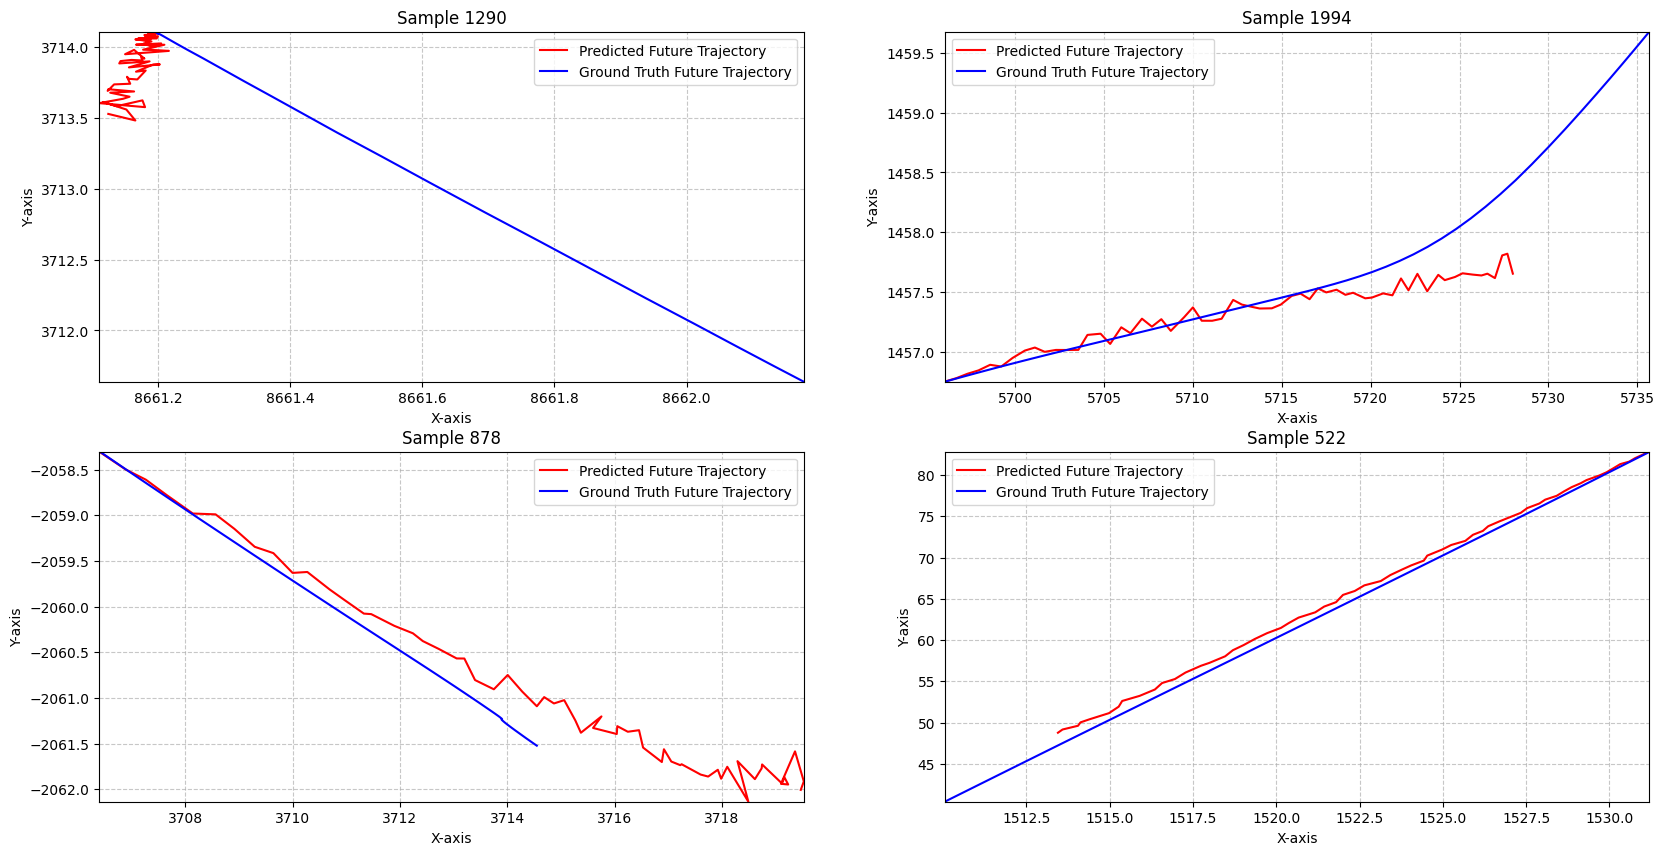

In [21]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [22]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = AdvancedTransformerModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = EnhancedTransformerModel(
    input_dim=6,
    model_dim=256,
    num_heads=8,
    num_layers=4,
    dropout=0
).to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())

pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B